<a href="https://colab.research.google.com/github/zainabintech/DDoS-Detection-System-/blob/main/Copy_of_part_2_model_training_and_evaluation_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import datetime
from collections import Counter

# ML libraries
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

# Google Colab specific imports
from google.colab import drive

# Set random state for reproducibility
RANDOM_STATE = 42

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("talk")

# Current timestamp for saving files
model_timestamp = time.strftime("%Y%m%d_%H%M")

# For warning suppression (optional)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data Loading
def load_data(timestamp, data_path):
    """
    Load the preprocessed datasets and prepare for model training.
    Uses the full dataset without sampling.
    """
    print(f"Loading datasets with timestamp: {timestamp}")
    train_df = pd.read_csv(f"{data_path}train_dataset_{timestamp}.csv")
    test_df = pd.read_csv(f"{data_path}test_dataset_{timestamp}.csv")

    print(f"Using the complete training dataset with {train_df.shape[0]} samples")

    # Separate features and target
    X_train_scaled = train_df.drop(columns=['Label'])
    y_train_res = train_df['Label']
    X_test_scaled = test_df.drop(columns=['Label'])
    y_test = test_df['Label']

    # Extract class names if available in the data, otherwise use generic names
    if 'class_names' in locals():
        pass
    else:
        class_names = [
            "Benign/Normal Traffic",
            "LDAP DDoS",
            "MSSQL DDoS",
            "NetBIOS DDoS",
            "Portmap DDoS",
            "Syn DDoS",
            "UDP DDoS",
            "UDPLag DDoS"
        ]

    print("Dataset Information:")
    print(f"Training set: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Test set: {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features")

    print("Training class distribution:")
    train_dist = Counter(y_train_res)
    for label, count in sorted(train_dist.items()):
        print(f"{class_names[label]}: {count} samples")

    print("Test class distribution:")
    test_dist = Counter(y_test)
    for label, count in sorted(test_dist.items()):
        print(f"{class_names[label]}: {count} samples")

    return X_train_scaled, y_train_res, X_test_scaled, y_test, class_names

# Mount Google Drive
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Specify data path and timestamp
timestamp = "20250516_203816"
data_path = "/content/drive/MyDrive/data/"

# Load the data using the full dataset
print("Loading data...")
X_train_scaled, y_train_res, X_test_scaled, y_test, class_names = load_data(
    timestamp,
    data_path
)
print("Data loading completed!")


Mounting Google Drive...
Mounted at /content/drive
Loading data...
Loading datasets with timestamp: 20250516_203816
Using the complete training dataset with 358865 samples
Dataset Information:
Training set: 358865 samples, 9 features
Test set: 198524 samples, 9 features
Training class distribution:
Benign/Normal Traffic: 44858 samples
LDAP DDoS: 44859 samples
MSSQL DDoS: 44858 samples
NetBIOS DDoS: 44858 samples
Portmap DDoS: 44858 samples
Syn DDoS: 44858 samples
UDP DDoS: 44858 samples
UDPLag DDoS: 44858 samples
Test class distribution:
Benign/Normal Traffic: 711 samples
LDAP DDoS: 19584 samples
MSSQL DDoS: 56073 samples
NetBIOS DDoS: 35582 samples
Portmap DDoS: 1851 samples
Syn DDoS: 46627 samples
UDP DDoS: 38075 samples
UDPLag DDoS: 21 samples
Data loading completed!


In [ ]:
# Model Evaluation Functions
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name,
                         data_path="./data/", has_feature_importance=True):
    """
    Train and evaluate a machine learning model with extensive metrics and visualizations.
    PRIMARY METRIC: Test F1-Score (Macro)
    SECONDARY METRIC: PR AUC (Macro)
    IMPORTANT METRIC: CV F1-Score (for consistency evaluation)
    """
    print(f"Initializing {model_name}...")

    # Cross-validation metrics
    print(f"Running 5-fold cross-validation...")
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    cv_start_time = time.time()
    cv_results = cross_validate(model, X_train, y_train,
                               cv=5, scoring=scoring, n_jobs=-1)
    cv_time = time.time() - cv_start_time

    # Store CV F1 score for later reporting
    cv_f1 = cv_results['test_f1'].mean()

    print(f"{model_name} Cross-Validation Metrics:")
    print(f"Mean CV F1-Score: {cv_f1:.4f} (IMPORTANT METRIC)")
    print(f"Mean CV Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"Mean CV Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"Mean CV Recall: {cv_results['test_recall'].mean():.4f}")
    print(f"Cross-validation time: {cv_time:.2f} seconds")

    # Train on full training set
    print(f"Training {model_name} on full training set...")
    train_start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - train_start_time
    print(f"Model training completed in {train_time:.2f} seconds")

    # Evaluate on test set
    print(f"Evaluating {model_name} on test set...")
    inference_start_time = time.time()
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    inference_time = time.time() - inference_start_time

    # Calculate performance metrics
    test_f1 = f1_score(y_test, y_pred, average='macro')

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(y_test, y_pred, average=None)

    # Calculate per-class precision and recall
    per_class_precision = precision_score(y_test, y_pred, average=None)
    per_class_recall = recall_score(y_test, y_pred, average=None)

    # Calculate PR AUC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
    avg_prec_values = [
        average_precision_score(y_test_bin[:, i], y_proba[:, i])
        for i in range(n_classes)
    ]
    pr_auc_macro = np.mean(avg_prec_values)

    # Highlight key metrics
    print("\nKey Performance Metrics:")
    print(f"Test F1-Score: {test_f1:.4f} (PRIMARY METRIC)")
    print(f"PR AUC (macro): {pr_auc_macro:.4f} (SECONDARY METRIC)")
    print(f"CV F1-Score: {cv_f1:.4f} (IMPORTANT METRIC)")

    # Original detailed evaluation
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_pred, digits=4, target_names=class_names))
    print(f"Inference time: {inference_time:.2f} seconds")

    # Generate model-specific visualizations
    print(f"Generating visualizations for {model_name}...")
    create_evaluation_visualizations(
        model, model_name, X_test, y_test, y_pred, y_proba, class_names,
        data_path, model_timestamp, has_feature_importance
    )

    # Generate per-class performance visualizations
    print(f"Generating per-class performance visualizations for {model_name}...")
    create_class_performance_visualizations(
        model_name, per_class_f1, per_class_precision, per_class_recall,
        avg_prec_values, class_names, data_path, model_timestamp
    )

    # Calculate overall metrics
    roc_auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')

    print(f"ROC AUC (OvR): {roc_auc_ovr:.4f}")
    print(f"PR AUC (Macro): {pr_auc_macro:.4f} (SECONDARY METRIC)")

    # Save the model
    model_filename = f"{data_path}{model_name.lower().replace(' ', '_')}_{model_timestamp}.joblib"
    joblib.dump(model, model_filename)
    print(f"{model_name} saved to {model_filename}")

    # Create metrics dictionary for model comparison
    metrics_dict = {
        'model_name': model_name,
        'test_f1': test_f1,
        'pr_auc': pr_auc_macro,
        'cv_f1': cv_f1,
        'cv_accuracy': cv_results['test_accuracy'].mean(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'roc_auc': roc_auc_ovr,
        'train_time': train_time,
        'inference_time': inference_time,
        'total_time': cv_time + train_time + inference_time
    }

    # Add per-class F1 scores to dictionary
    for i, class_name in enumerate(class_names):
        metrics_dict[f'f1_{class_name.replace(" ", "_")}'] = per_class_f1[i]
        metrics_dict[f'pr_auc_{class_name.replace(" ", "_")}'] = avg_prec_values[i]

    print(f"{model_name} evaluation completed!")
    print(f"SUMMARY: Test F1-Score = {test_f1:.4f} (PRIMARY), PR AUC = {pr_auc_macro:.4f} (SECONDARY), CV F1-Score = {cv_f1:.4f}")
    return metrics_dict, model

def create_class_performance_visualizations(model_name, per_class_f1, per_class_precision, per_class_recall,
                                           per_class_pr_auc, class_names, data_path, timestamp):
    """
    Create and save visualizations showing model performance across different classes
    """
    model_short = model_name.lower().replace(' ', '_')

    # 1. Per-Class F1 Scores
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, per_class_f1, color='#5DA5DA')
    plt.title(f'{model_name} F1 Score by Class', fontsize=16)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Highlight highest and lowest performing classes
    best_class_idx = np.argmax(per_class_f1)
    worst_class_idx = np.argmin(per_class_f1)
    bars[best_class_idx].set_color('#60BD68')  # Green for best
    bars[worst_class_idx].set_color('#F15854')  # Red for worst

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_f1_scores_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Per-Class PR AUC Scores
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, per_class_pr_auc, color='#F17CB0')
    plt.title(f'{model_name} PR AUC by Class', fontsize=16)
    plt.ylabel('PR AUC', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Highlight highest and lowest performing classes
    best_class_idx = np.argmax(per_class_pr_auc)
    worst_class_idx = np.argmin(per_class_pr_auc)
    bars[best_class_idx].set_color('#60BD68')  # Green for best
    bars[worst_class_idx].set_color('#F15854')  # Red for worst

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_pr_auc_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Precision and Recall by Class
    plt.figure(figsize=(14, 8))
    x = np.arange(len(class_names))
    width = 0.35

    plt.bar(x - width/2, per_class_precision, width, label='Precision', color='#B2912F')
    plt.bar(x + width/2, per_class_recall, width, label='Recall', color='#4C72B0')

    plt.title(f'{model_name} Precision and Recall by Class', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add value labels
    for i, v in enumerate(per_class_precision):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(per_class_recall):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_precision_recall_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

def create_evaluation_visualizations(model, model_name, X_test, y_test, y_pred, y_proba,
                                    class_names, data_path, timestamp,
                                    has_feature_importance=True):
    """
    Create and save standard evaluation visualizations.
    """
    model_short = model_name.lower().replace(' ', '_')
    n_classes = len(class_names)

    # 1. Confusion Matrix
    print(f"Creating confusion matrix for {model_name}...")
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix (Normalized)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_confusion_matrix_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. ROC Curves
    print(f"Creating ROC curves for {model_name}...")
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curves - One-vs-Rest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_roc_curves_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Precision-Recall Curves
    print(f"Creating Precision-Recall curves for {model_name}...")
    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        avg_prec = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, lw=2,
                 label=f'P-R curve of class {class_names[i]} (AP = {avg_prec:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curves (SECONDARY METRIC)')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_pr_curves_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Feature Importance (if available)
    if has_feature_importance:
        print(f"Creating feature importance plot for {model_name}...")
        try:
            # Different models have different ways to access feature importance
            if hasattr(model, 'feature_importances_'):
                # Random Forest, XGBoost, LightGBM
                importances = model.feature_importances_
                feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

                # Sort features by importance
                indices = np.argsort(importances)[-20:]  # Top features

                plt.figure(figsize=(12, 8))
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.xlabel('Feature Importance')
                plt.title(f'{model_name} Feature Importance')
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

            # Handle model-specific plotting functions
            elif model_name.startswith('XGBoost'):
                plt.figure(figsize=(12, 8))
                xgb.plot_importance(model, height=0.8, max_num_features=20)
                plt.title(f"XGBoost Feature Importance")
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

            elif model_name.startswith('LightGBM'):
                plt.figure(figsize=(12, 8))
                lgb.plot_importance(model, height=0.8, max_num_features=20)
                plt.title(f"LightGBM Feature Importance")
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

        except Exception as e:
            print(f"Could not create feature importance plot: {e}")

Initializing KNN Classifier...
Initializing KNN Classifier...
Running 5-fold cross-validation...
KNN Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8499
Mean CV Accuracy: 0.8663
Mean CV Precision: 0.8723
Mean CV Recall: 0.8663
Cross-validation time: 237.98 seconds
Training KNN Classifier on full training set...
Model training completed in 0.94 seconds
Evaluating KNN Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.7284 (PRIMARY METRIC)
PR AUC (macro): 0.7306 (SECONDARY METRIC)
CV F1-Score: 0.8499

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7662    0.9494    0.8480       711
            LDAP DDoS     0.9529    0.9969    0.9744     19584
           MSSQL DDoS     0.9885    0.9741    0.9813     56073
         NetBIOS DDoS     0.9464    0.7495    0.8365     35582
         Portmap DDoS     0.0394    0.1983    0.0658      1851
             Syn DDoS     0.9988    0.9935    0.9962     46627
    

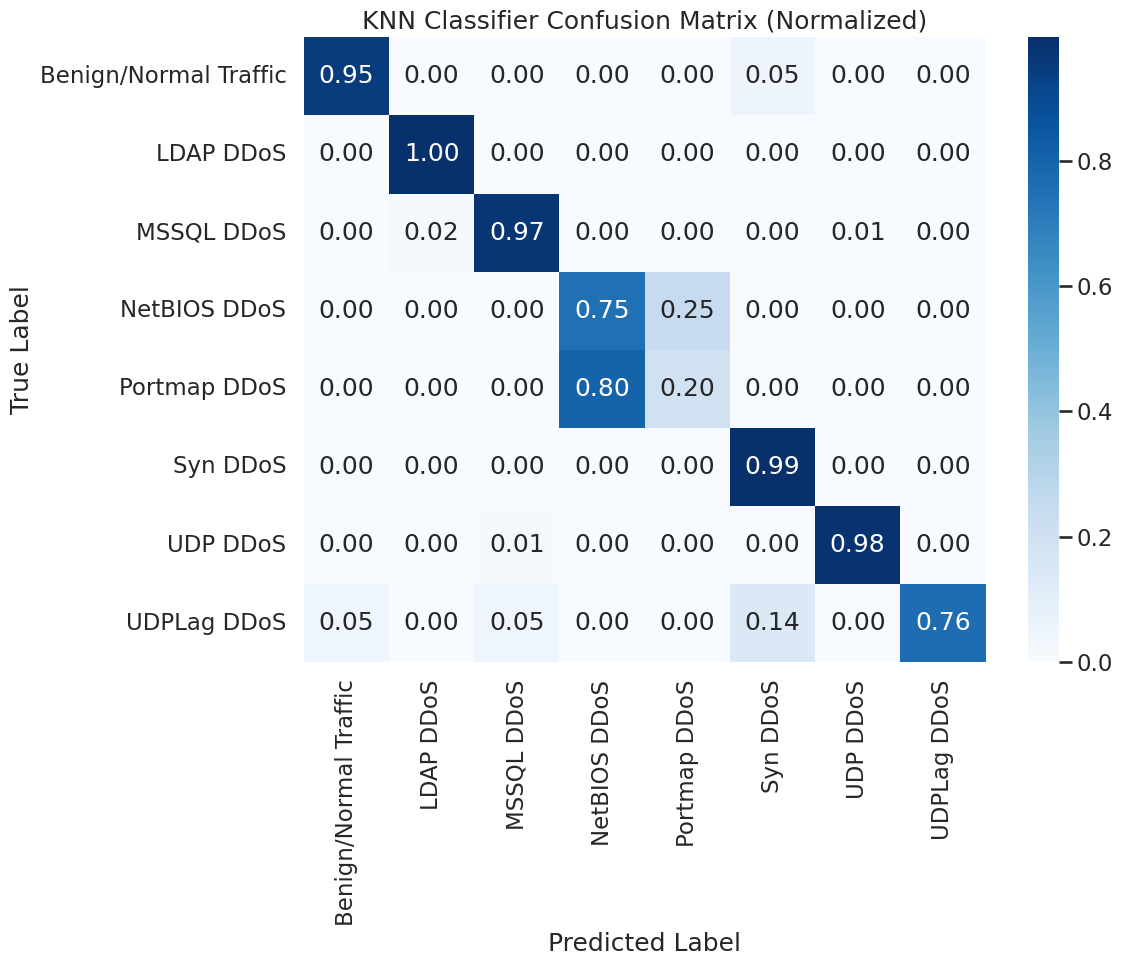

Creating ROC curves for KNN Classifier...


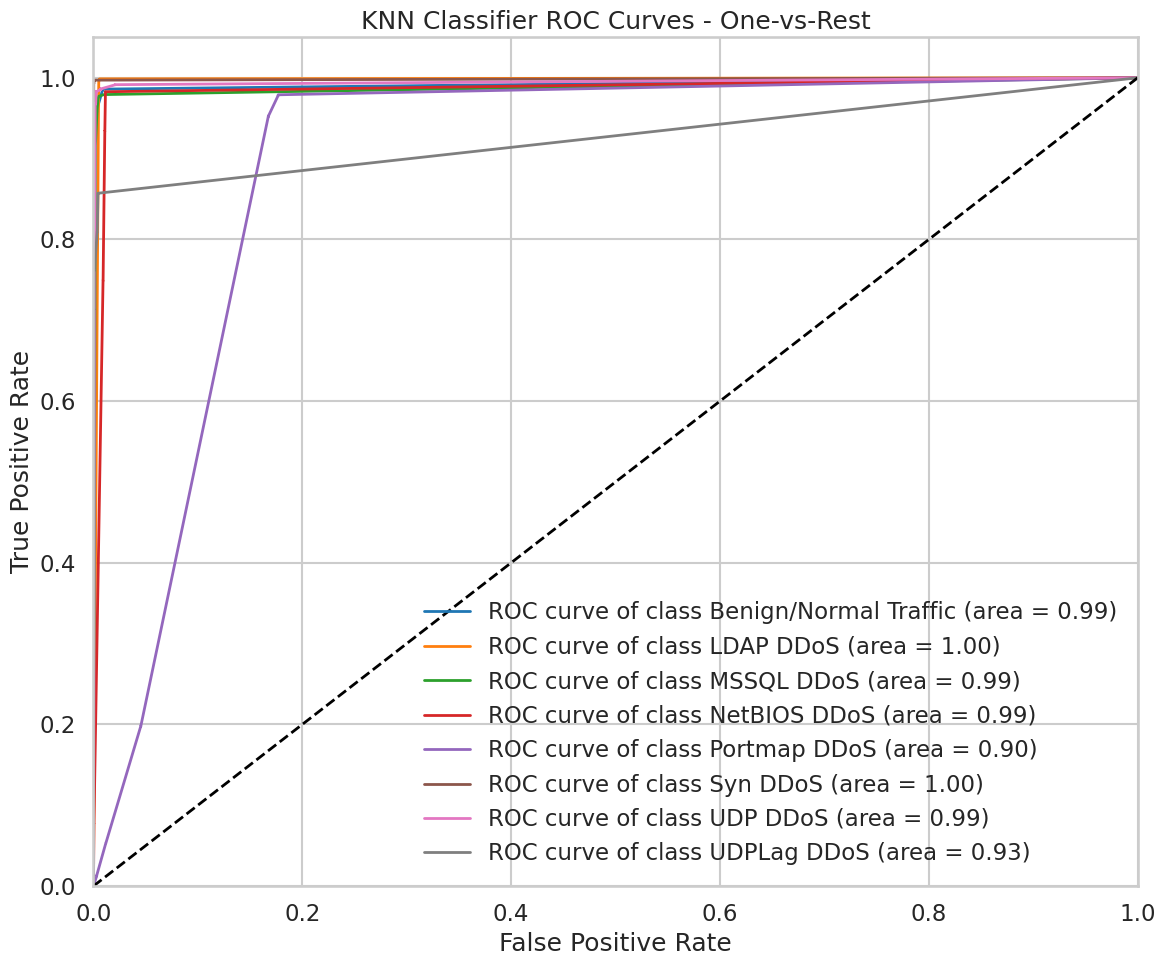

Creating Precision-Recall curves for KNN Classifier...


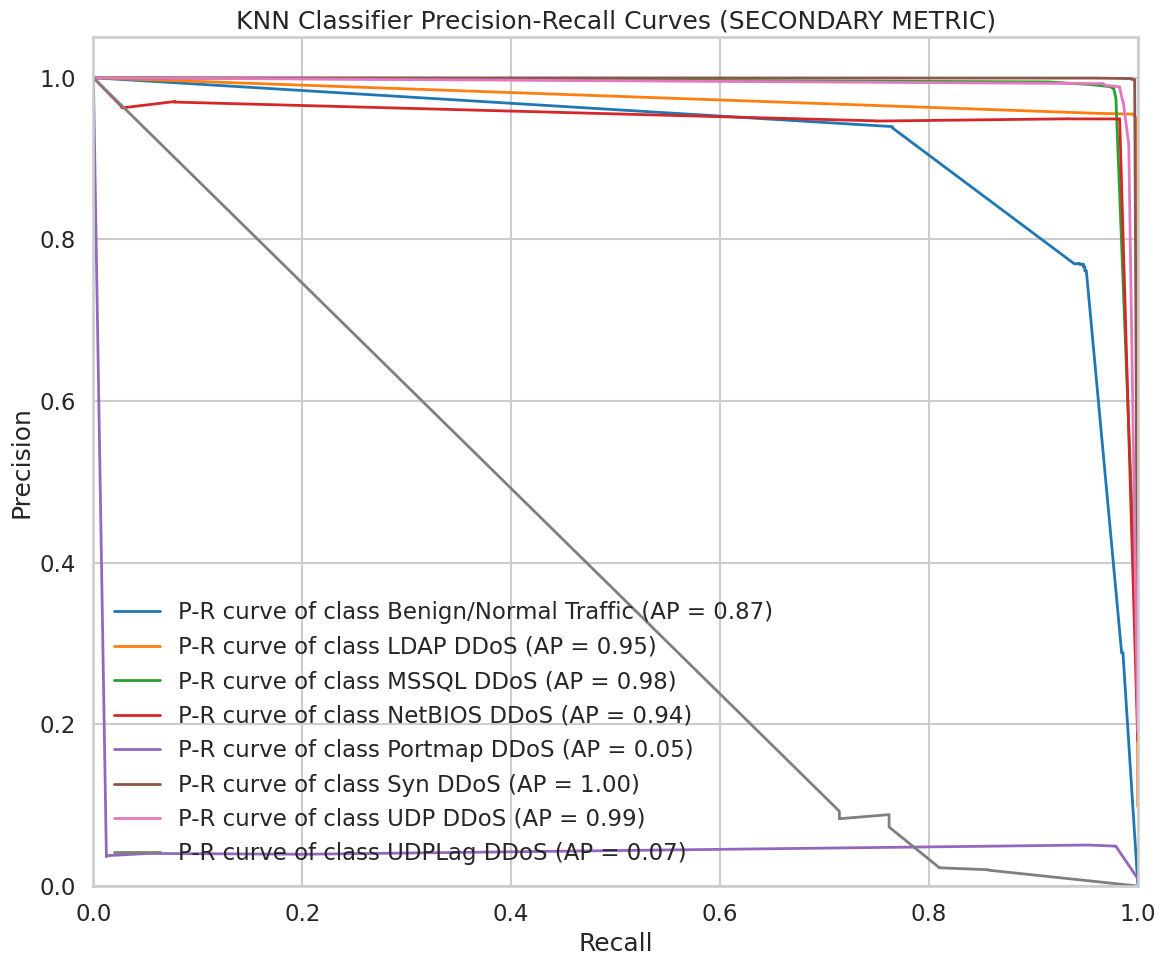

ROC AUC (OvR): 0.9728
PR AUC (Macro): 0.7306 (SECONDARY METRIC)
KNN Classifier saved to /content/drive/MyDrive/data/knn_classifier_20250516_2152.joblib
KNN Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.7284 (PRIMARY), PR AUC = 0.7306 (SECONDARY), CV F1-Score = 0.8499


In [ ]:
# K-Nearest Neighbors (KNN) Classifier
print("Initializing KNN Classifier...")

# Initialize KNN with the parameters that worked well
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='kd_tree',
    leaf_size=30,
    p=2,  # Euclidean distance
    n_jobs=-1
)

# Train and evaluate the model
knn_metrics, knn_model = train_evaluate_model(
    knn_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "KNN Classifier", data_path, has_feature_importance=False
)

Initializing Random Forest Classifier...
Initializing Random Forest Classifier...
Running 5-fold cross-validation...
Random Forest Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8617
Mean CV Accuracy: 0.8741
Mean CV Precision: 0.8831
Mean CV Recall: 0.8741
Cross-validation time: 220.27 seconds
Training Random Forest Classifier on full training set...
Model training completed in 54.97 seconds
Evaluating Random Forest Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6735 (PRIMARY METRIC)
PR AUC (macro): 0.8107 (SECONDARY METRIC)
CV F1-Score: 0.8617

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7636    0.9451    0.8448       711
            LDAP DDoS     0.9536    0.9981    0.9753     19584
           MSSQL DDoS     0.9893    0.9748    0.9820     56073
         NetBIOS DDoS     0.9668    0.2388    0.3830     35582
         Portmap DDoS     0.0546    0.8449    0.1025      1851
             Syn

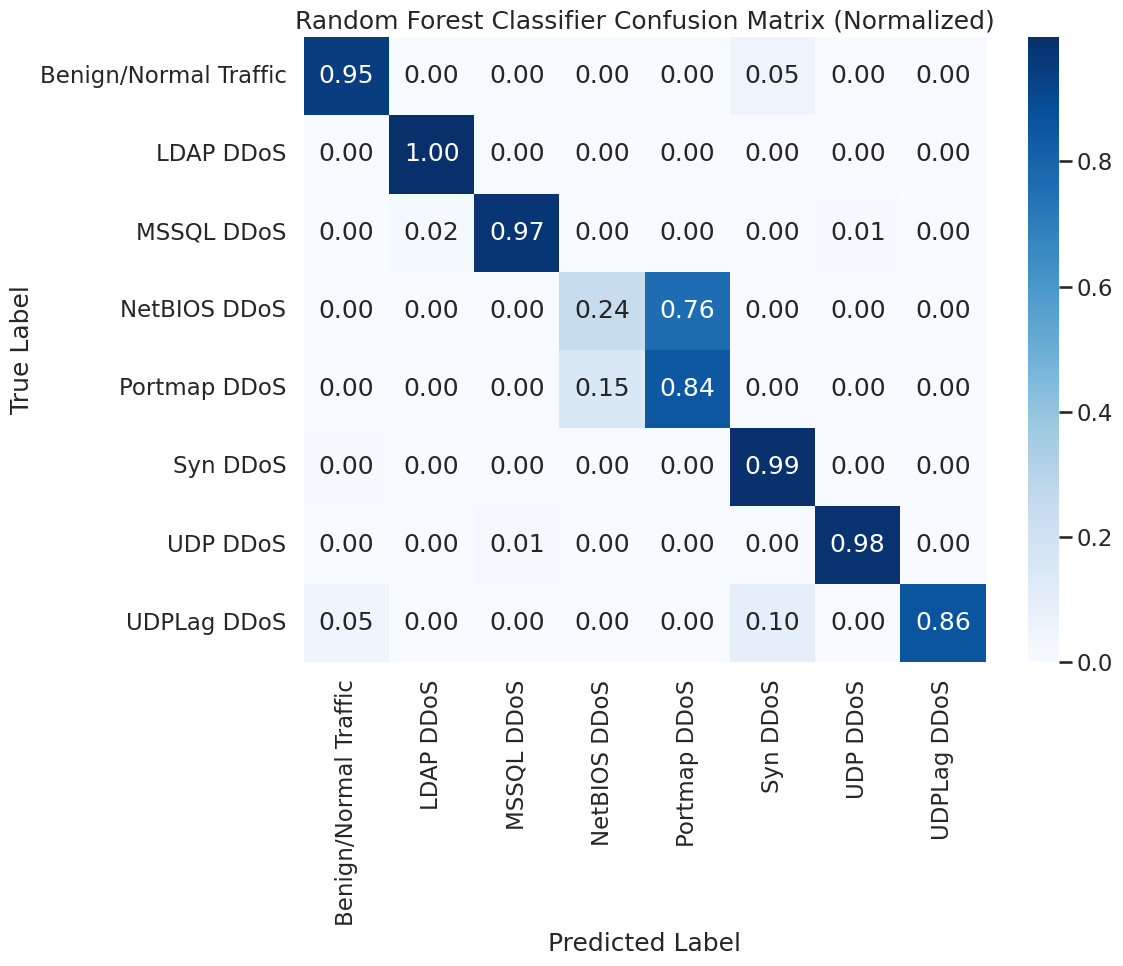

Creating ROC curves for Random Forest Classifier...


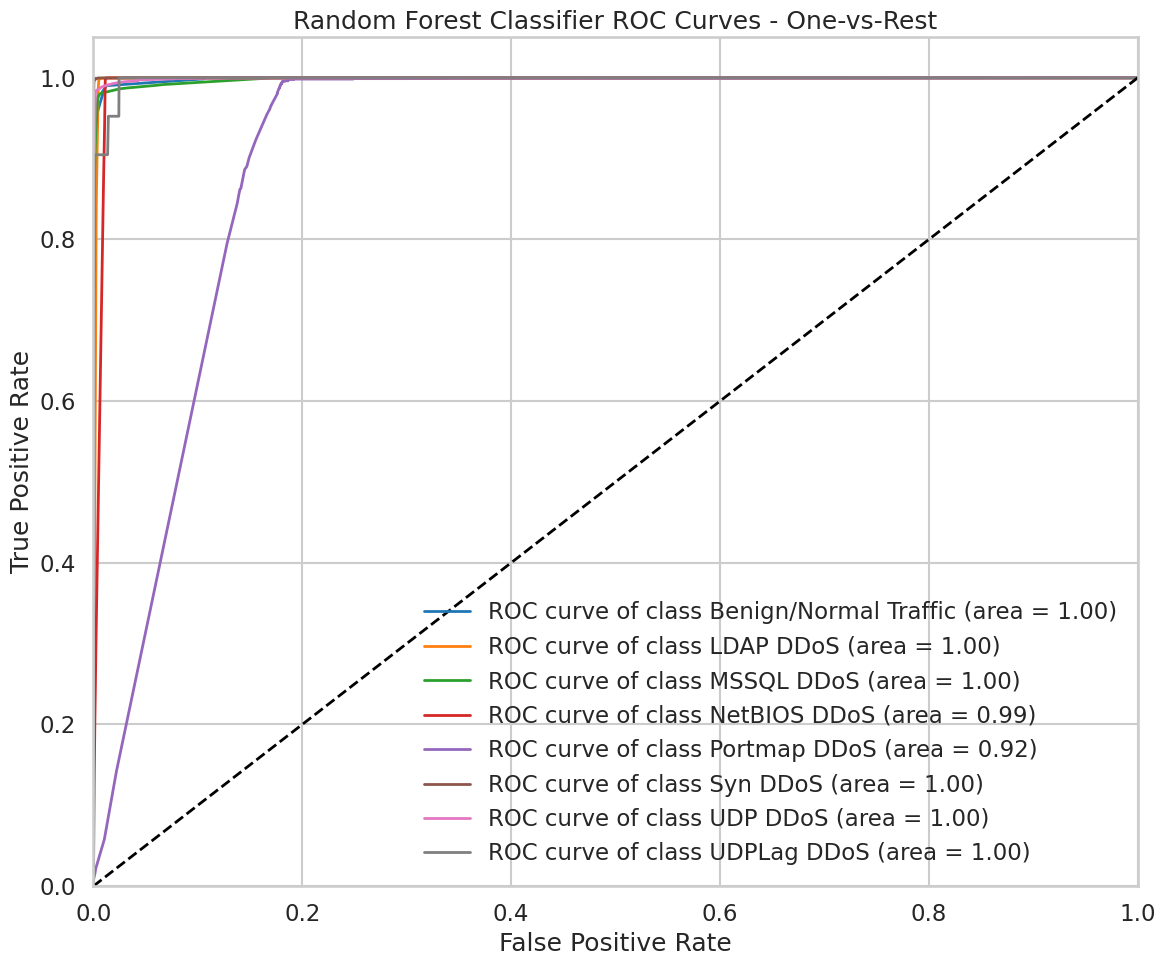

Creating Precision-Recall curves for Random Forest Classifier...


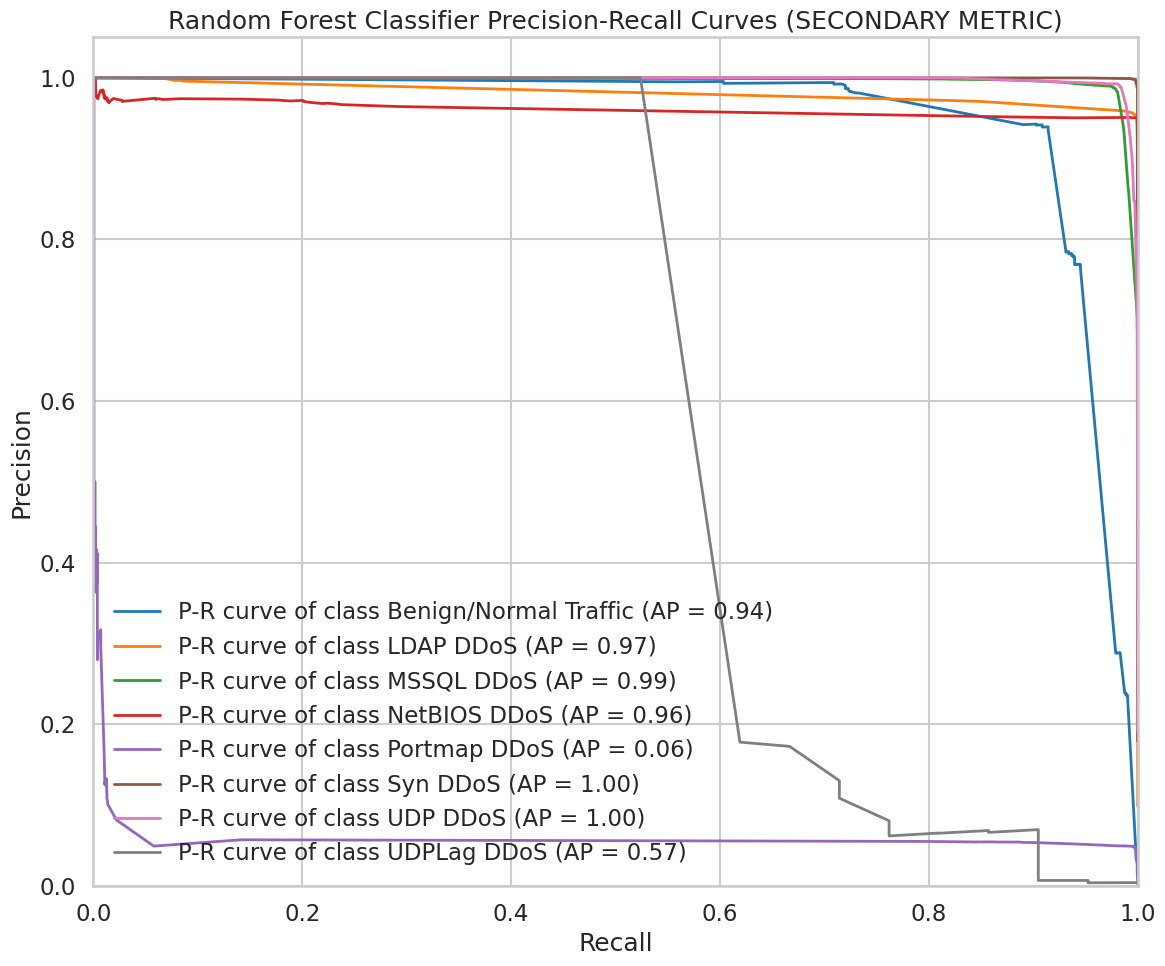

Creating feature importance plot for Random Forest Classifier...


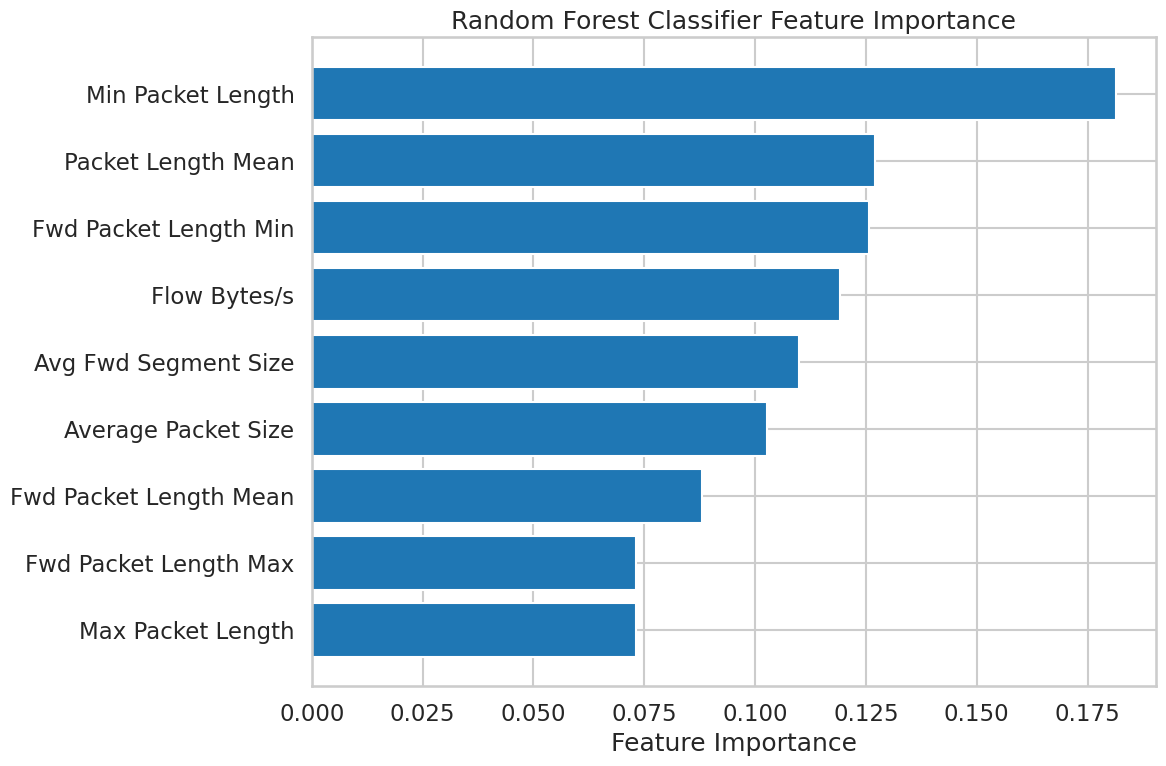

ROC AUC (OvR): 0.9882
PR AUC (Macro): 0.8107 (SECONDARY METRIC)
Random Forest Classifier saved to /content/drive/MyDrive/data/random_forest_classifier_20250516_2152.joblib
Random Forest Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6735 (PRIMARY), PR AUC = 0.8107 (SECONDARY), CV F1-Score = 0.8617


In [ ]:
# Random Forest Classifier
print("Initializing Random Forest Classifier...")

# Initialize Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate the model
rf_metrics, rf_model = train_evaluate_model(
    rf_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "Random Forest Classifier", data_path, has_feature_importance=True
)

Initializing XGBoost Classifier...
Initializing XGBoost Classifier...
Running 5-fold cross-validation...
XGBoost Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8573
Mean CV Accuracy: 0.8697
Mean CV Precision: 0.8782
Mean CV Recall: 0.8697
Cross-validation time: 372.02 seconds
Training XGBoost Classifier on full training set...
Model training completed in 97.06 seconds
Evaluating XGBoost Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6640 (PRIMARY METRIC)
PR AUC (macro): 0.8114 (SECONDARY METRIC)
CV F1-Score: 0.8573

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7545    0.9466    0.8397       711
            LDAP DDoS     0.9395    0.9917    0.9649     19584
           MSSQL DDoS     0.9854    0.9681    0.9767     56073
         NetBIOS DDoS     0.9667    0.2365    0.3800     35582
         Portmap DDoS     0.0547    0.8493    0.1027      1851
             Syn DDoS     0.9990    0.9913    

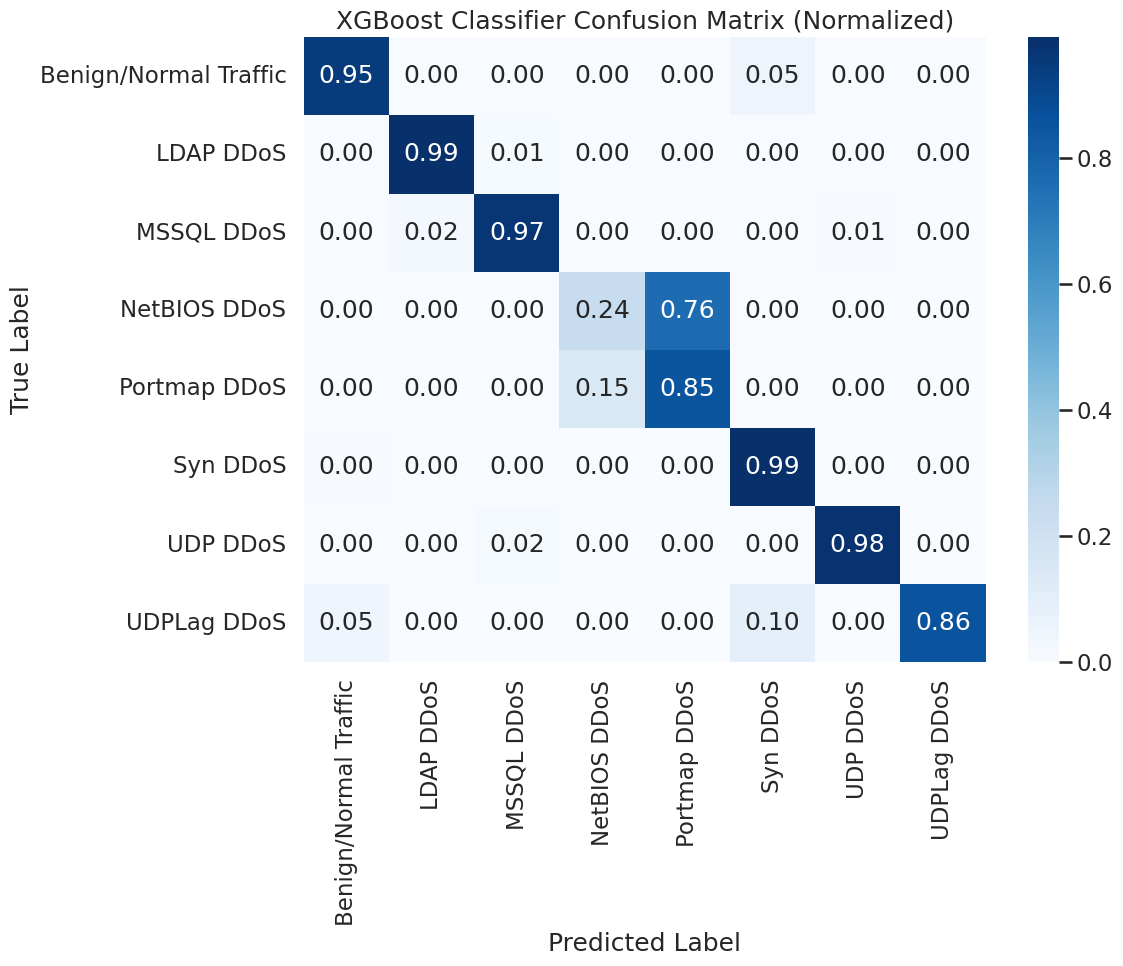

Creating ROC curves for XGBoost Classifier...


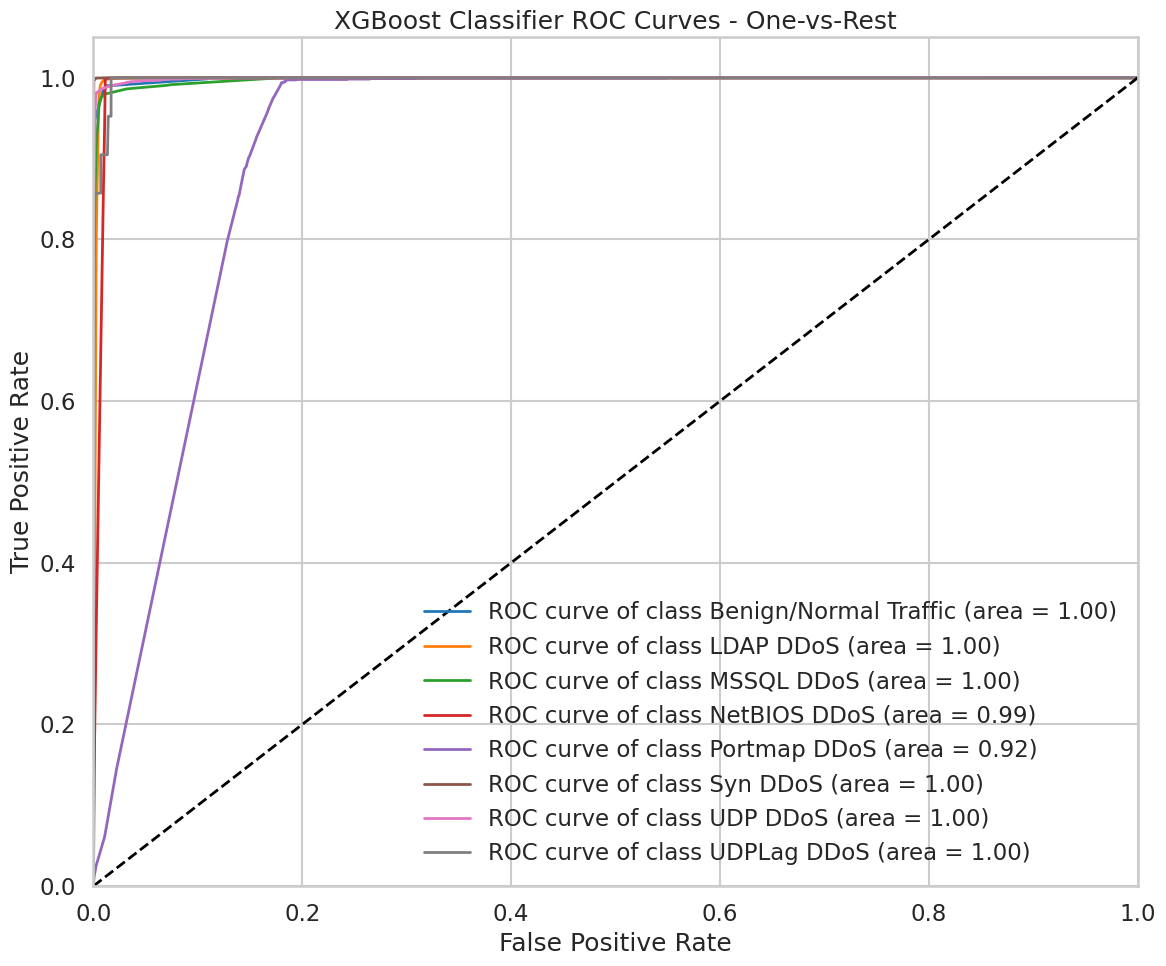

Creating Precision-Recall curves for XGBoost Classifier...


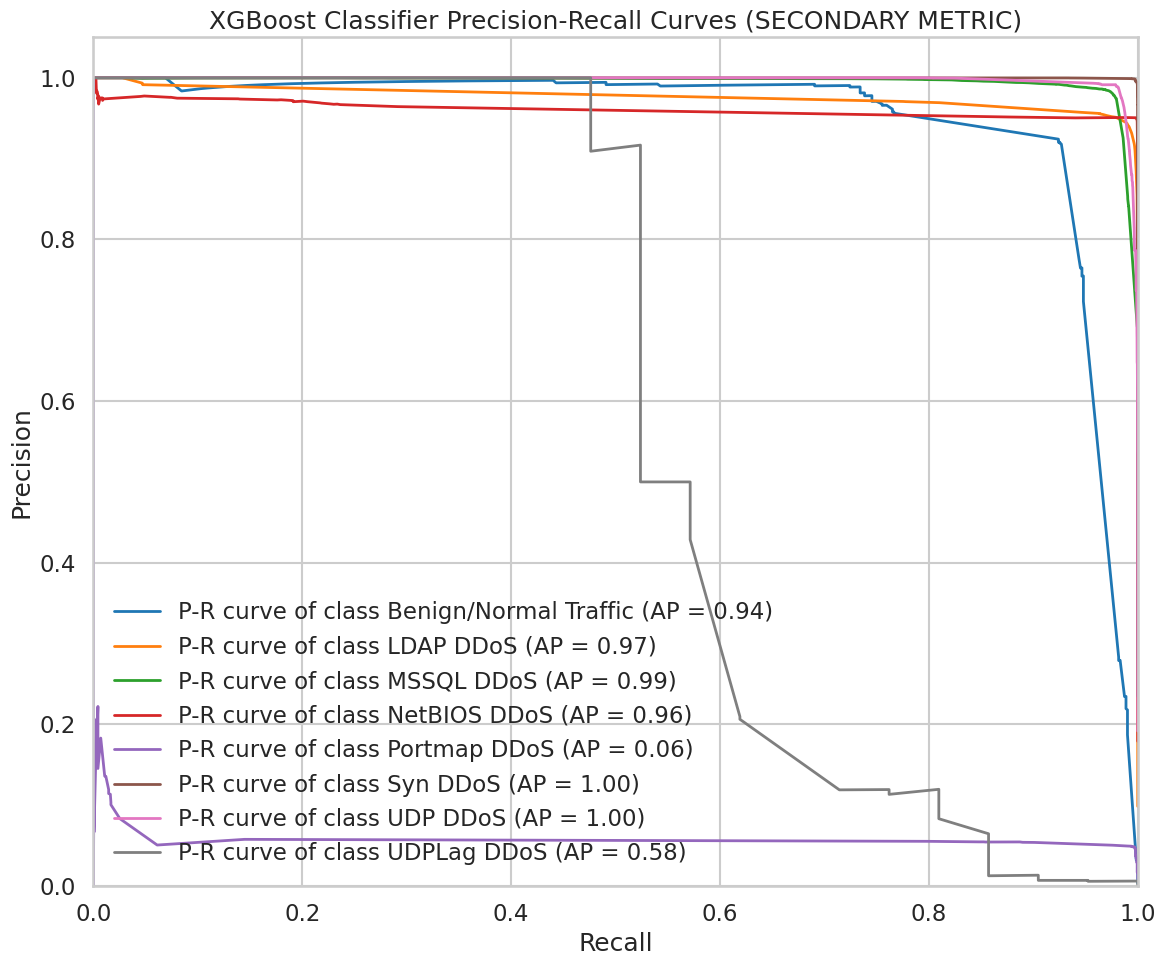

Creating feature importance plot for XGBoost Classifier...


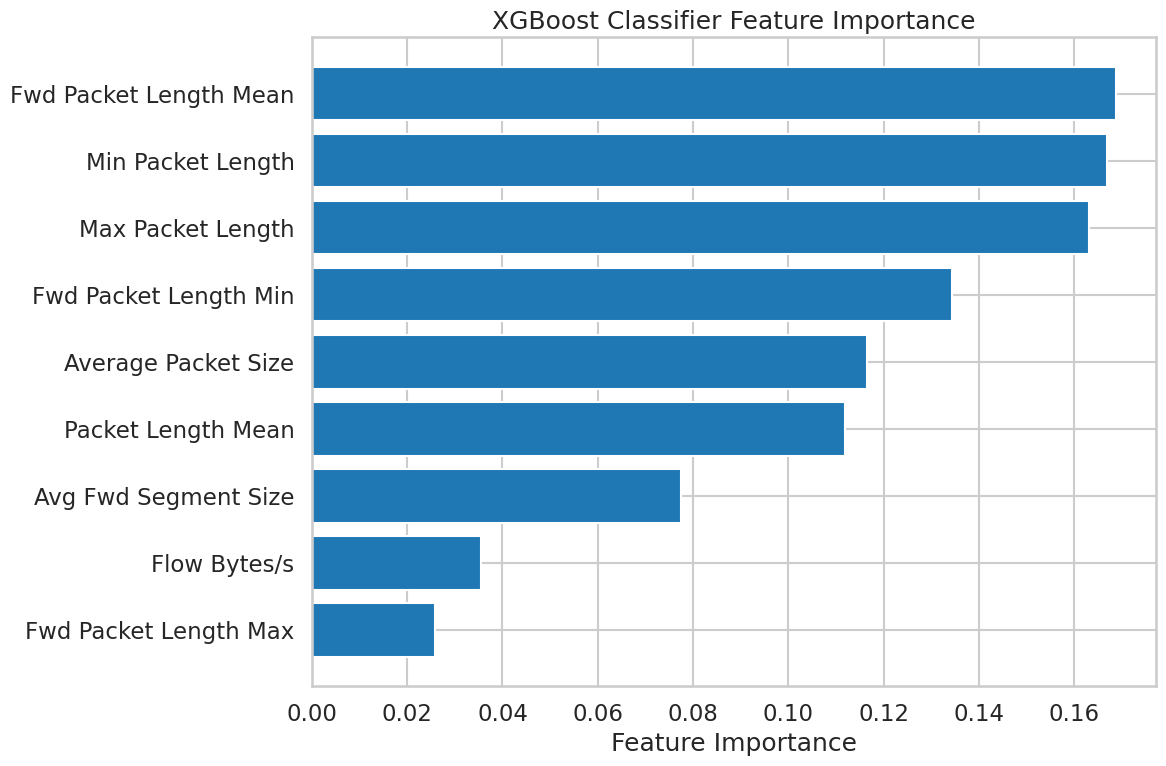

ROC AUC (OvR): 0.9882
PR AUC (Macro): 0.8114 (SECONDARY METRIC)
XGBoost Classifier saved to /content/drive/MyDrive/data/xgboost_classifier_20250516_2152.joblib
XGBoost Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6640 (PRIMARY), PR AUC = 0.8114 (SECONDARY), CV F1-Score = 0.8573


In [ ]:
# XGBoost Classifier
print("Initializing XGBoost Classifier...")

# Initialize XGBoost with multi-class parameters
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=8,
    learning_rate=0.2,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate the model
xgb_metrics, xgb_model = train_evaluate_model(
    xgb_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "XGBoost Classifier", data_path, has_feature_importance=True
)

Initializing LightGBM Classifier...
Initializing LightGBM Classifier...
Running 5-fold cross-validation...
LightGBM Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8598
Mean CV Accuracy: 0.8722
Mean CV Precision: 0.8810
Mean CV Recall: 0.8722
Cross-validation time: 1046.51 seconds
Training LightGBM Classifier on full training set...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 358865, number of used features: 9
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079441
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info]

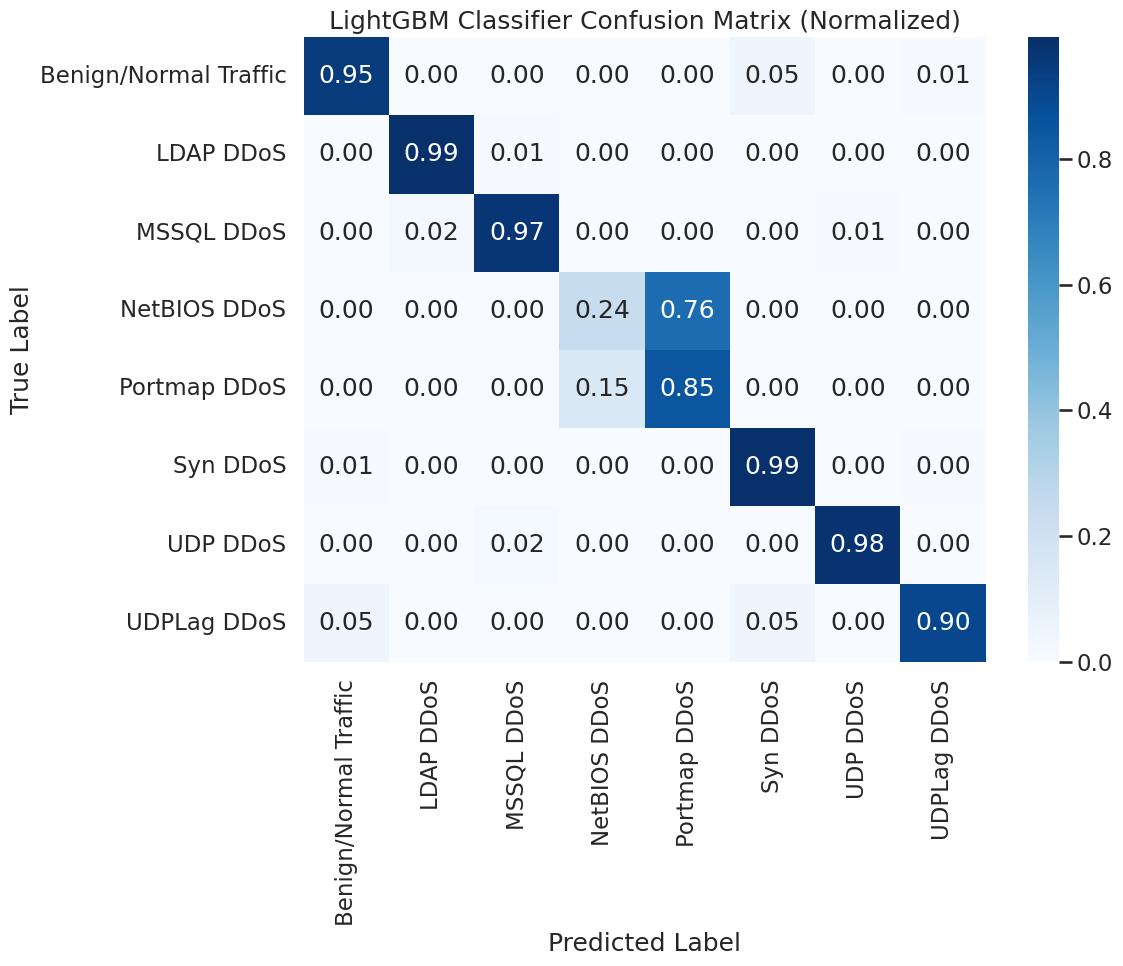

Creating ROC curves for LightGBM Classifier...


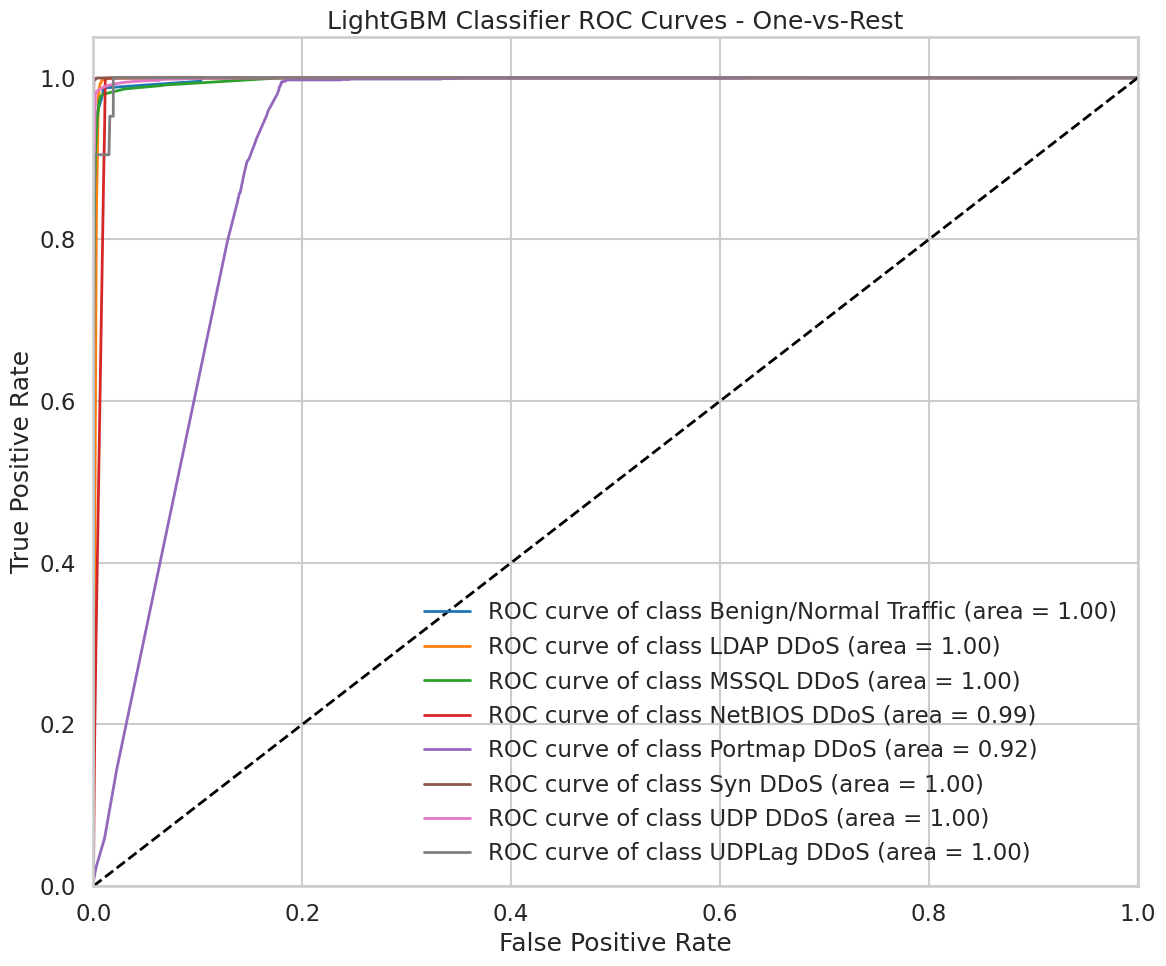

Creating Precision-Recall curves for LightGBM Classifier...


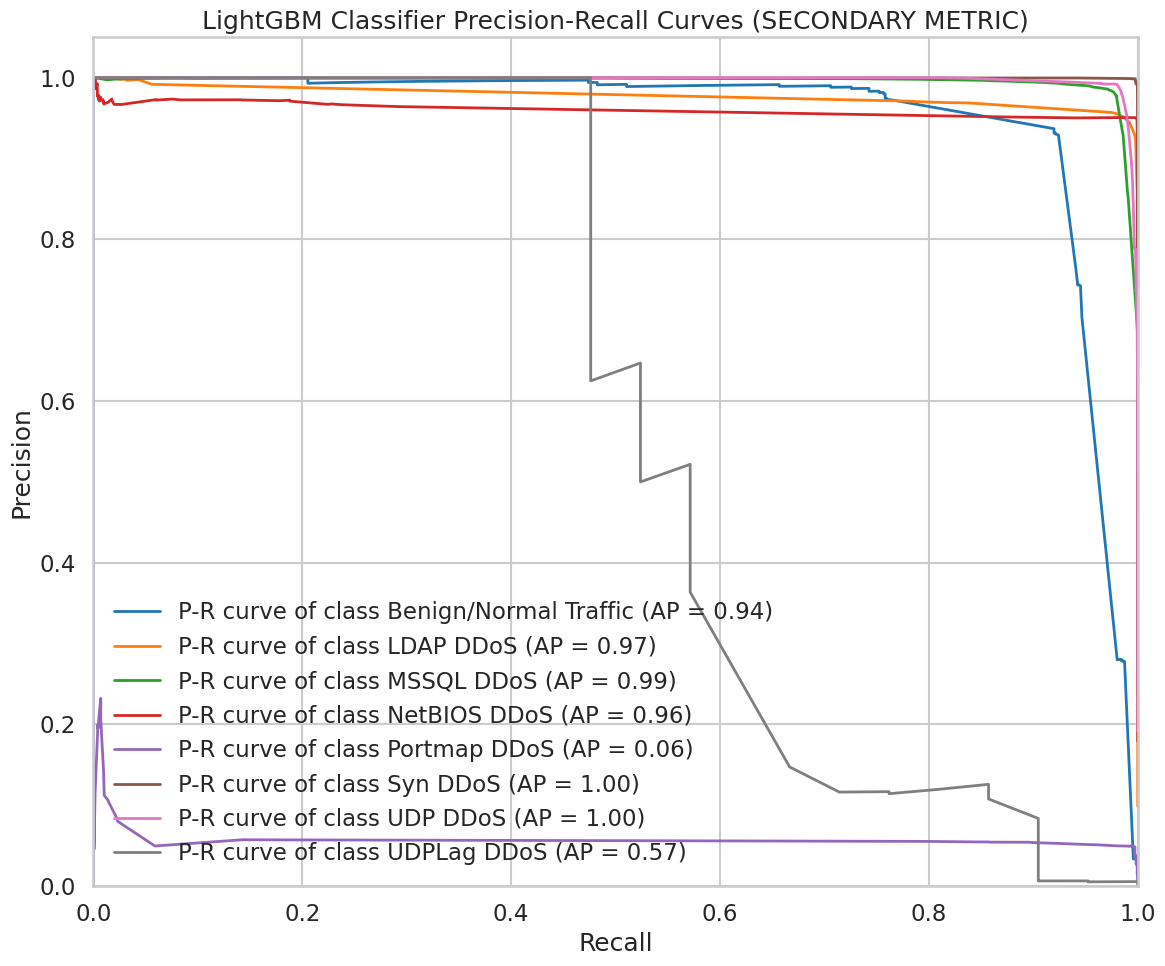

Creating feature importance plot for LightGBM Classifier...


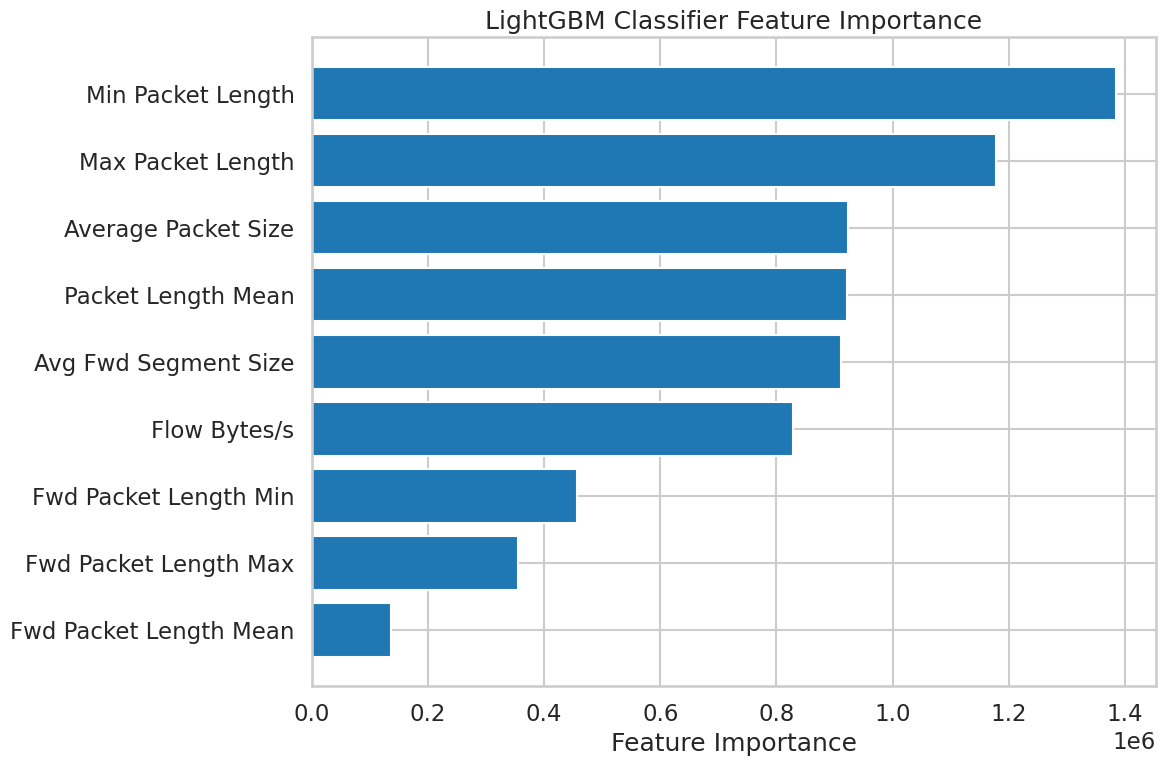

ROC AUC (OvR): 0.9881
PR AUC (Macro): 0.8108 (SECONDARY METRIC)
LightGBM Classifier saved to /content/drive/MyDrive/data/lightgbm_classifier_20250516_2152.joblib
LightGBM Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6619 (PRIMARY), PR AUC = 0.8108 (SECONDARY), CV F1-Score = 0.8598
Note: For early stopping in LightGBM, modify the train_evaluate_model function
to include callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]


In [ ]:
# LightGBM Classifier
print("Initializing LightGBM Classifier...")

# Initialize LightGBM with optimized parameters
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=8,
    learning_rate=0.1,
    max_depth=-1,  # Leaf-wise growth
    n_estimators=500,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    importance_type='gain'
)

# Train and evaluate the model with early stopping
lgb_metrics, lgb_model = train_evaluate_model(
    lgb_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "LightGBM Classifier", data_path, has_feature_importance=True
)

# Add early stopping during training (if desired)
print("Note: For early stopping in LightGBM, modify the train_evaluate_model function")
print("to include callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]")

Initializing Decision Tree Classifier...
Initializing Decision Tree Classifier...
Running 5-fold cross-validation...
Decision Tree Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8571
Mean CV Accuracy: 0.8696
Mean CV Precision: 0.8779
Mean CV Recall: 0.8696
Cross-validation time: 7.65 seconds
Training Decision Tree Classifier on full training set...
Model training completed in 3.08 seconds
Evaluating Decision Tree Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6639 (PRIMARY METRIC)
PR AUC (macro): 0.7625 (SECONDARY METRIC)
CV F1-Score: 0.8571

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7517    0.9409    0.8357       711
            LDAP DDoS     0.9538    0.9924    0.9727     19584
           MSSQL DDoS     0.9847    0.9737    0.9792     56073
         NetBIOS DDoS     0.9670    0.2389    0.3832     35582
         Portmap DDoS     0.0544    0.8412    0.1022      1851
             Syn DD

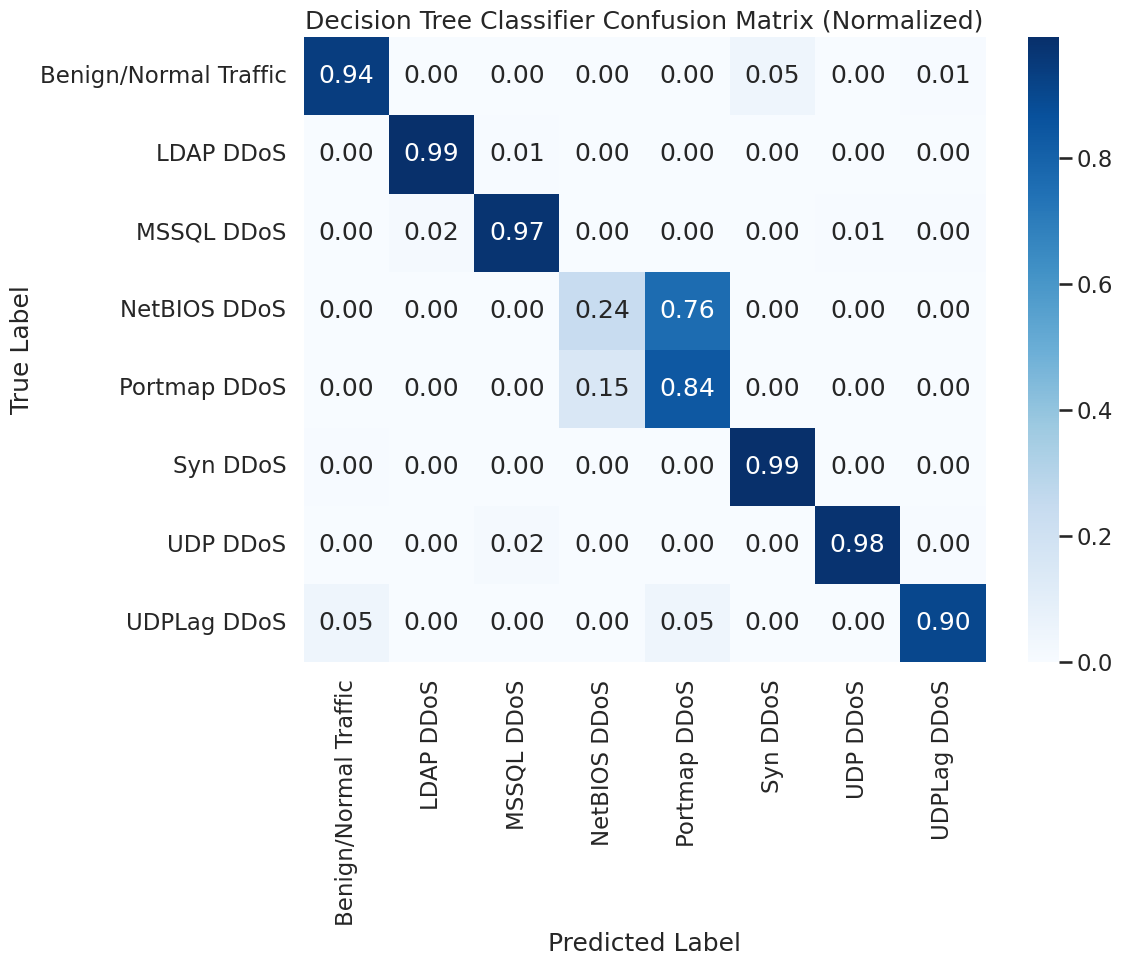

Creating ROC curves for Decision Tree Classifier...


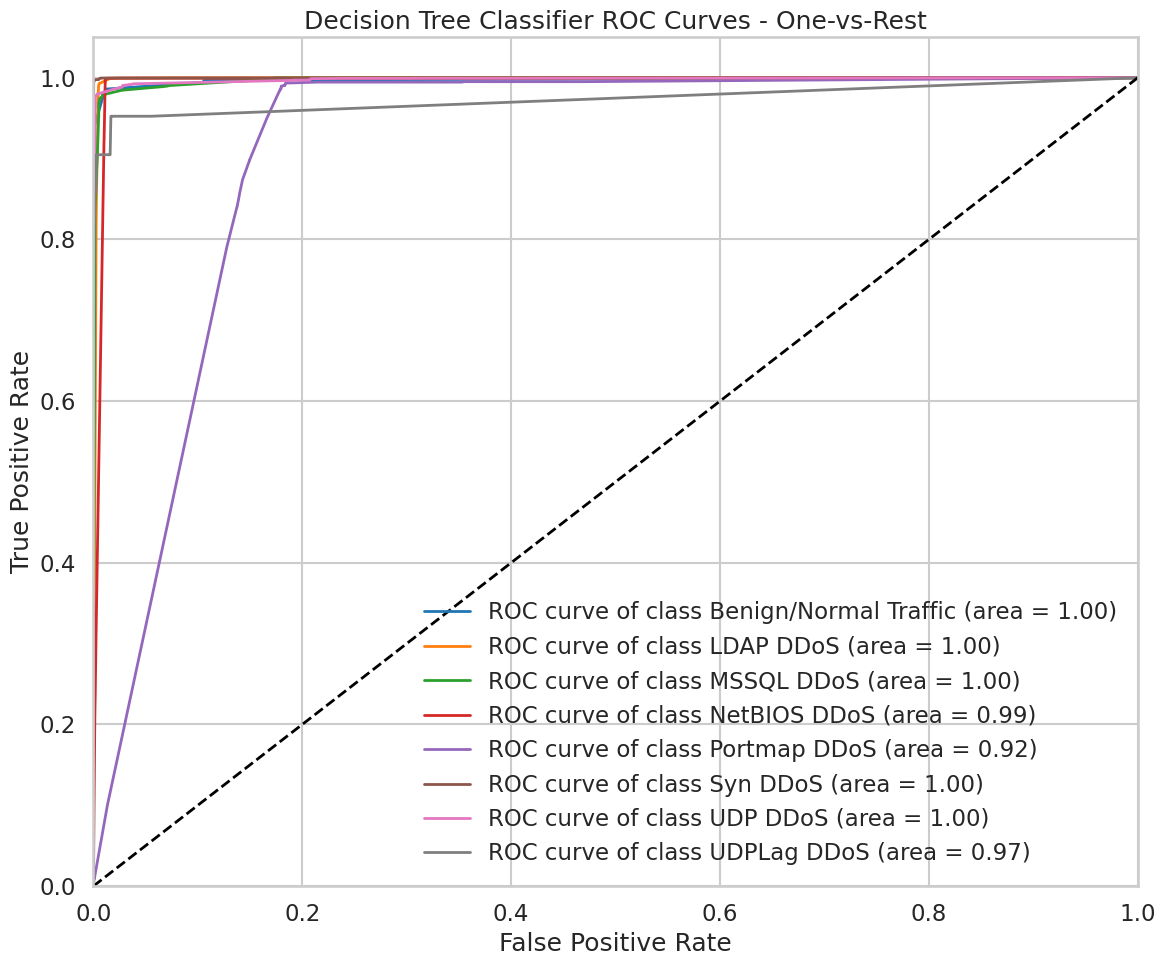

Creating Precision-Recall curves for Decision Tree Classifier...


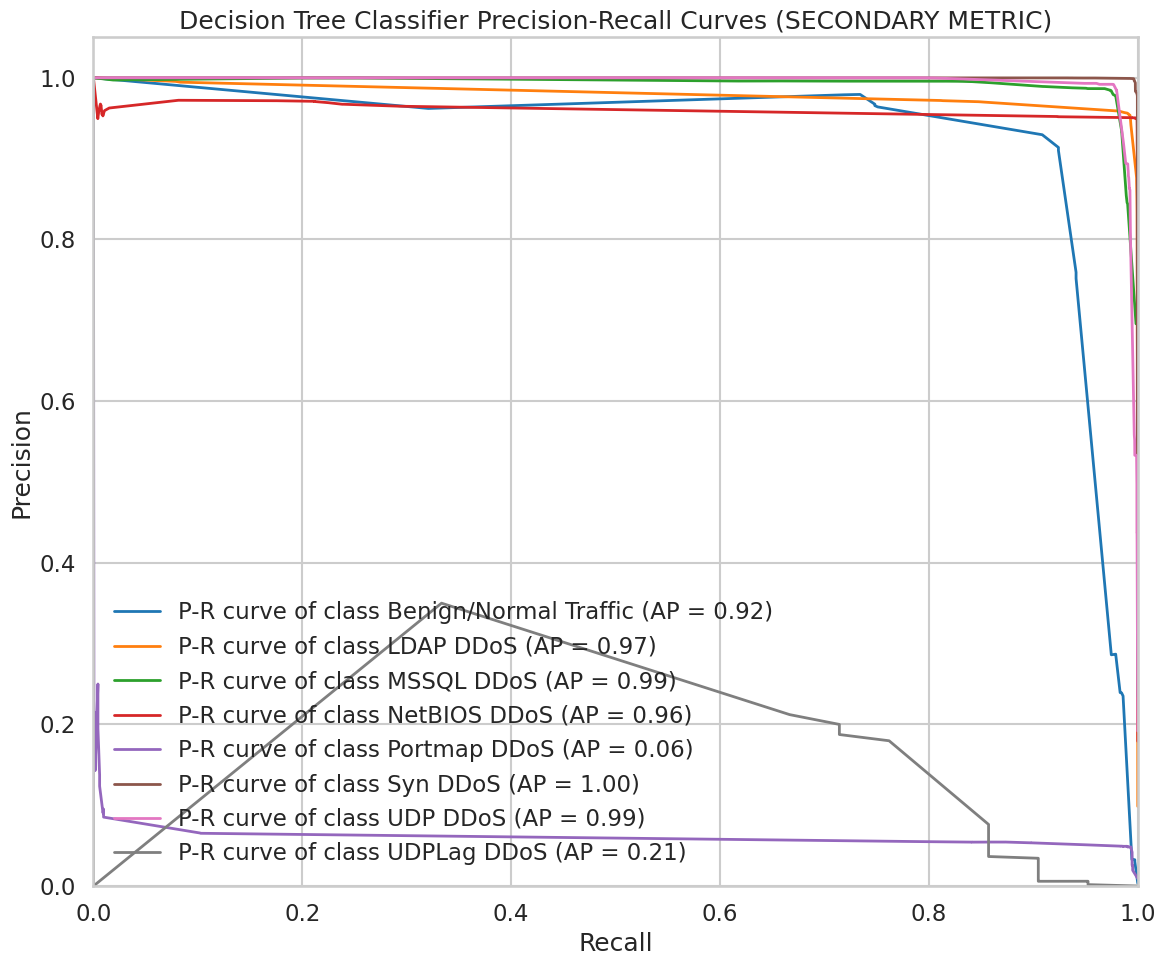

Creating feature importance plot for Decision Tree Classifier...


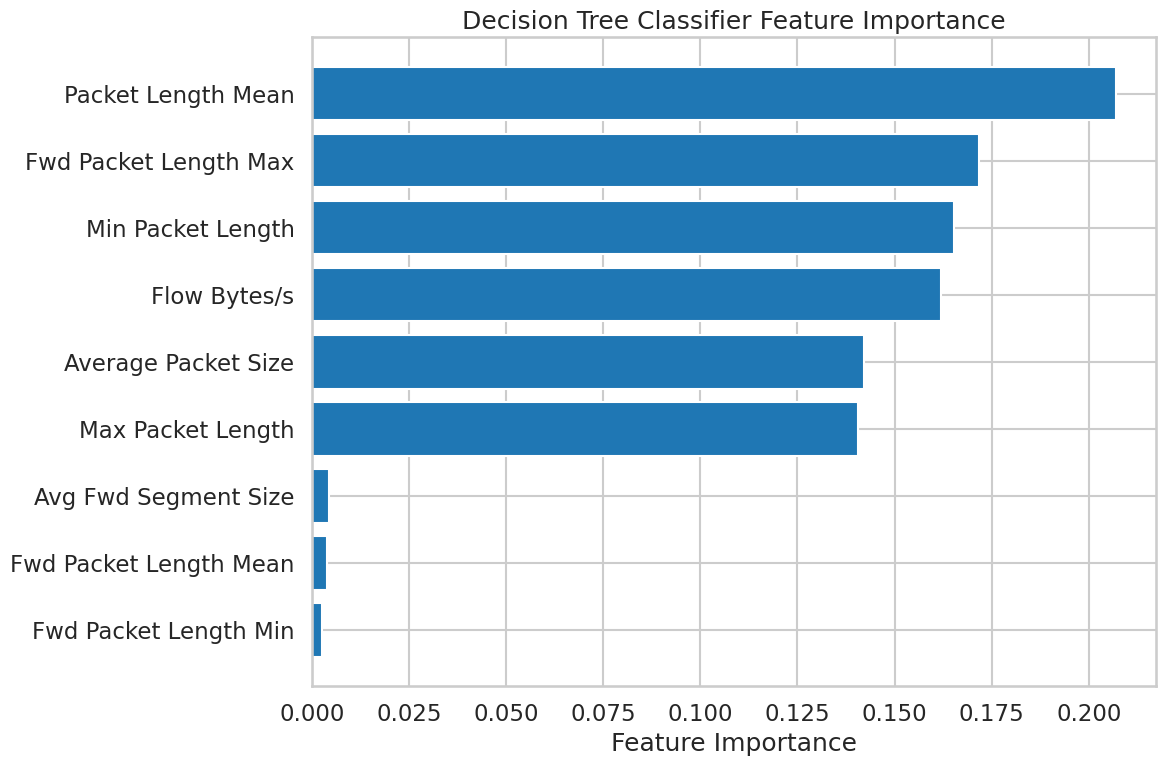

ROC AUC (OvR): 0.9844
PR AUC (Macro): 0.7625 (SECONDARY METRIC)
Decision Tree Classifier saved to /content/drive/MyDrive/data/decision_tree_classifier_20250516_2152.joblib
Decision Tree Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6639 (PRIMARY), PR AUC = 0.7625 (SECONDARY), CV F1-Score = 0.8571


In [ ]:
# Decision Tree Classifier
print("Initializing Decision Tree Classifier...")

# Initialize Decision Tree with optimized parameters
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini',
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Train and evaluate the model
dt_metrics, dt_model = train_evaluate_model(
    dt_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "Decision Tree Classifier", data_path, has_feature_importance=True
)

Starting model comparison...
Saved model comparison to /content/drive/MyDrive/data/model_comparison_20250516_2152.csv

MODEL COMPARISON - PERFORMANCE METRICS (ordered by priority)
                          test_f1  pr_auc   cv_f1  roc_auc  cv_accuracy  \
model_name                                                                
Random Forest Classifier   0.6735  0.8107  0.8617   0.9882       0.8741   
KNN Classifier             0.7284  0.7306  0.8499   0.9728       0.8663   
XGBoost Classifier         0.6640  0.8114  0.8573   0.9882       0.8697   
LightGBM Classifier        0.6619  0.8108  0.8598   0.9881       0.8722   
Decision Tree Classifier   0.6639  0.7625  0.8571   0.9844       0.8696   

                          cv_precision  cv_recall  
model_name                                         
Random Forest Classifier        0.8831     0.8741  
KNN Classifier                  0.8723     0.8663  
XGBoost Classifier              0.8782     0.8697  
LightGBM Classifier             0.

<Figure size 1500x1000 with 0 Axes>

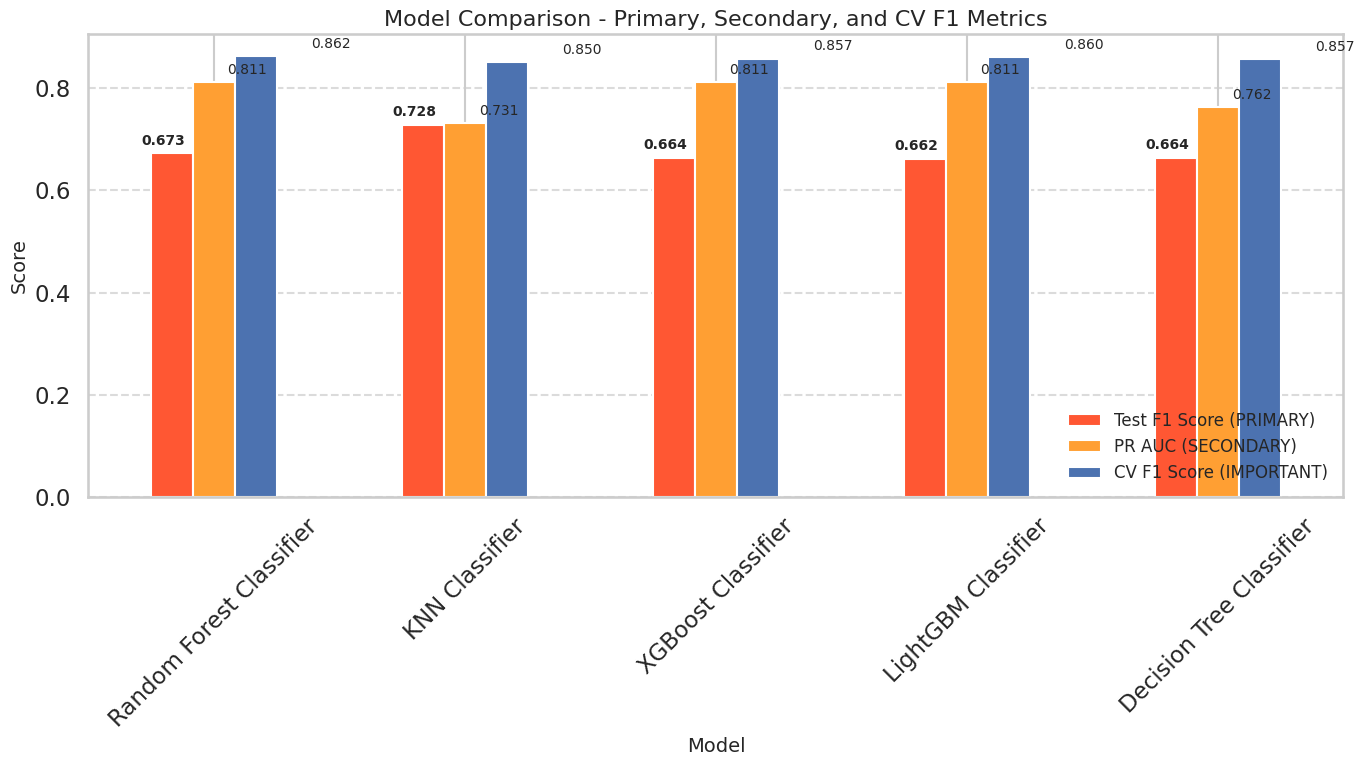

<Figure size 1500x1000 with 0 Axes>

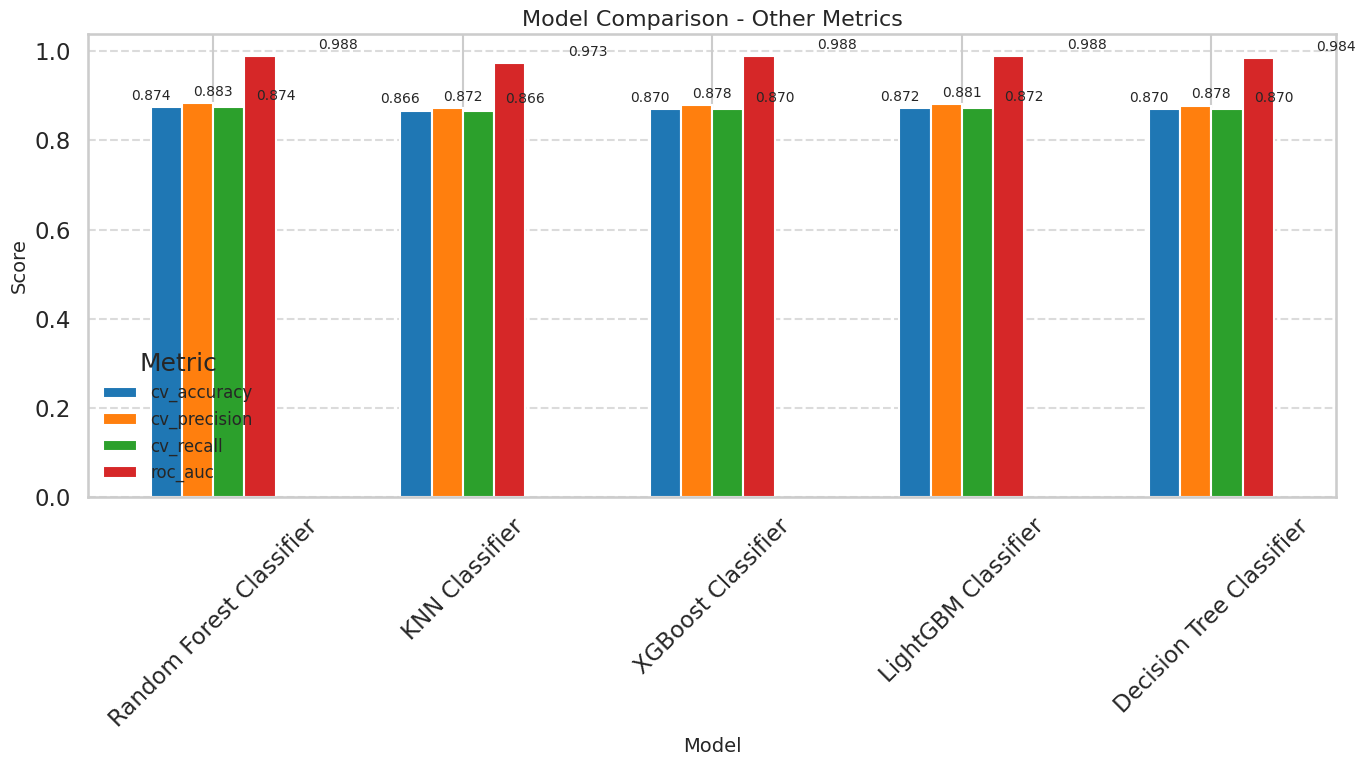

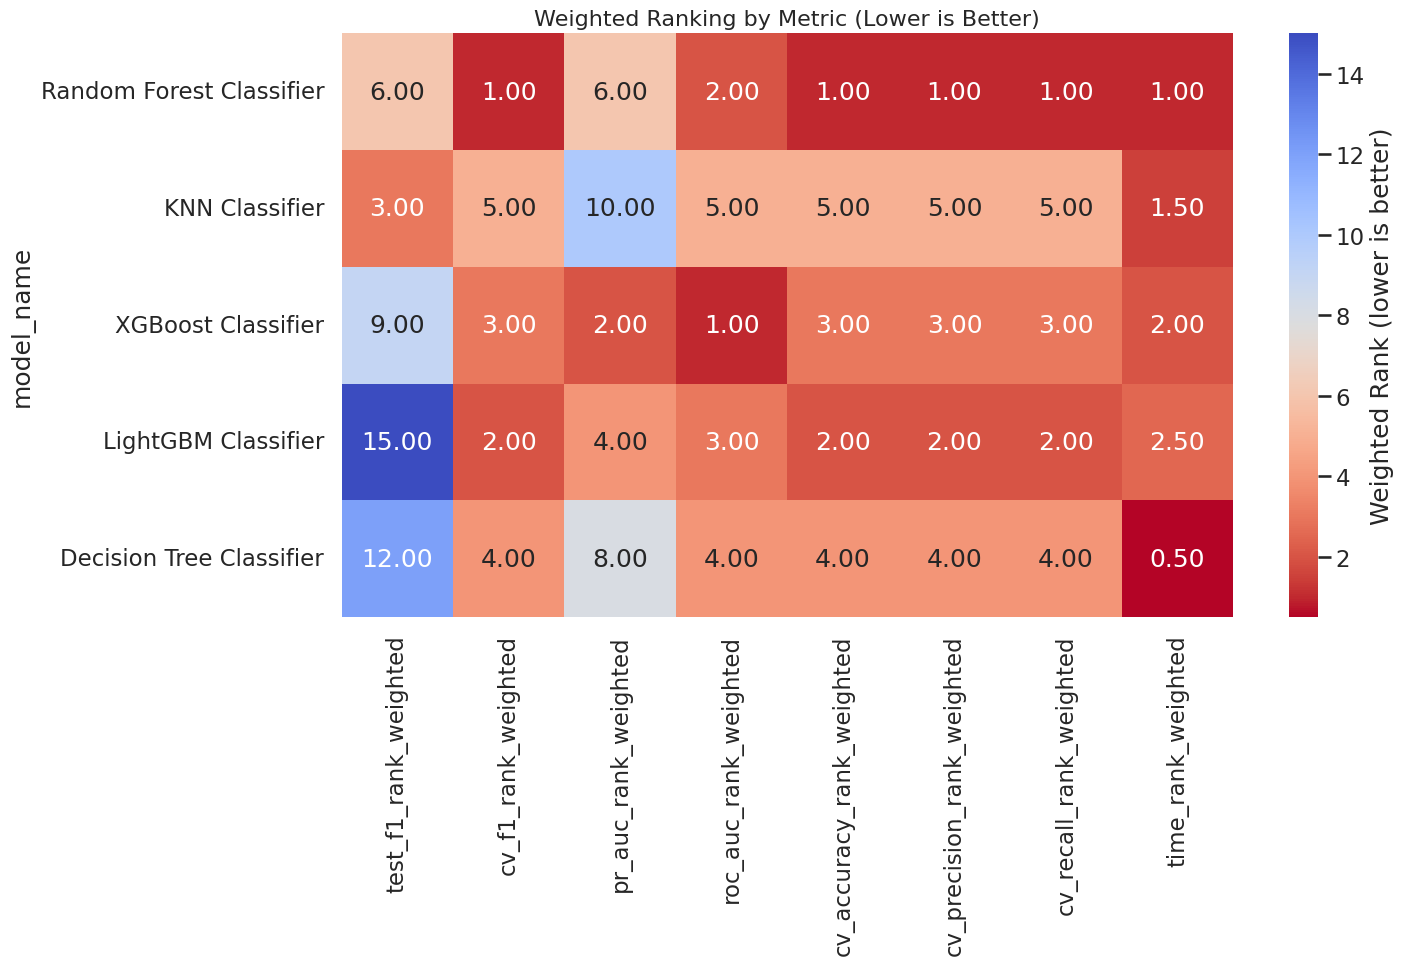

<Figure size 1400x800 with 0 Axes>

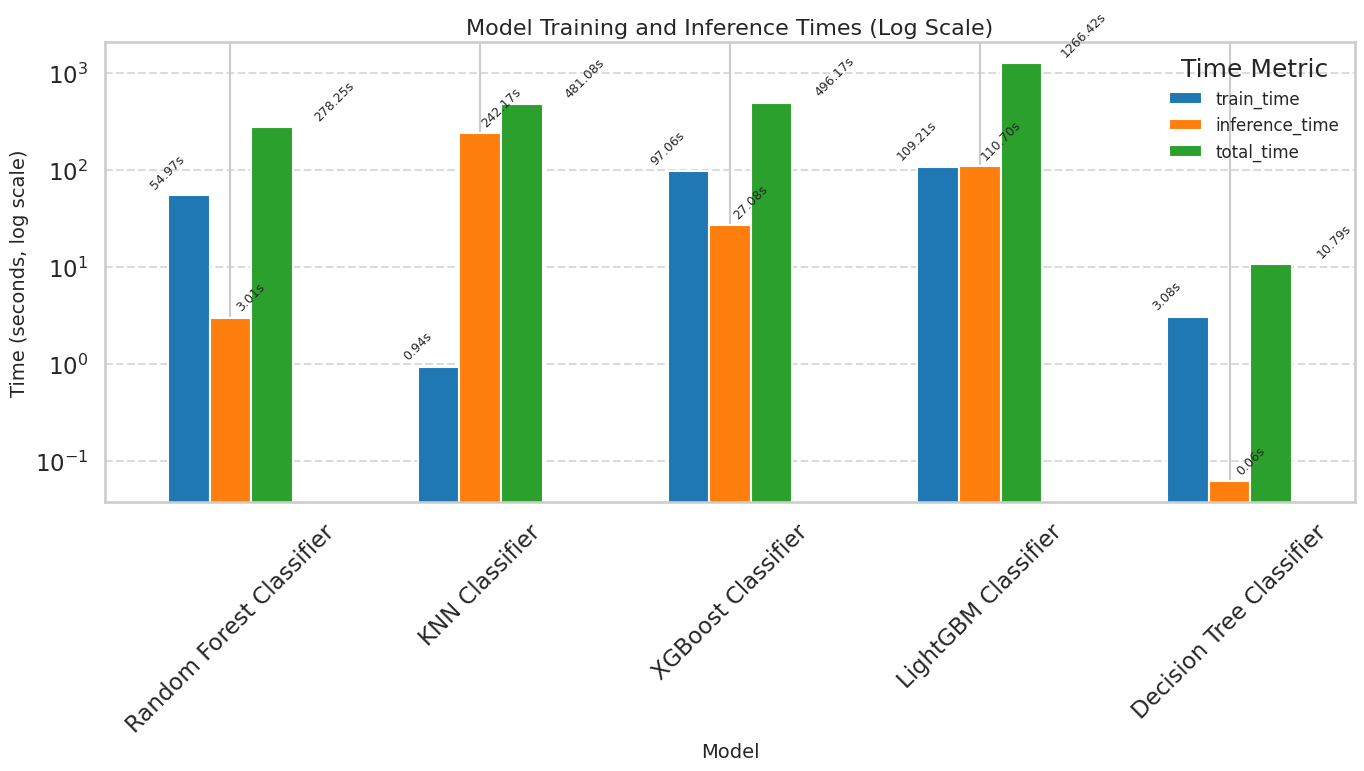


OVERALL BEST MODEL SELECTION (with weighted metrics)
Model Rankings (weighted, lower is better):
                          test_f1_rank_weighted  cv_f1_rank_weighted  \
model_name                                                             
Random Forest Classifier                    6.0                  1.5   
KNN Classifier                              3.0                  7.5   
XGBoost Classifier                          9.0                  4.5   
LightGBM Classifier                        15.0                  3.0   
Decision Tree Classifier                   12.0                  6.0   

                          pr_auc_rank_weighted  roc_auc_rank_weighted  \
model_name                                                              
Random Forest Classifier                   6.0                    2.0   
KNN Classifier                            10.0                    5.0   
XGBoost Classifier                         2.0                    1.0   
LightGBM Classifier             

In [ ]:
# Model Comparison
print("Starting model comparison...")

# Collect all metrics
all_metrics = [rf_metrics, knn_metrics, xgb_metrics, lgb_metrics, dt_metrics]
metrics_df = pd.DataFrame(all_metrics)

# Set model name as index
metrics_df.set_index('model_name', inplace=True)

# Save metrics to CSV
metrics_filename = f"{data_path}model_comparison_{model_timestamp}.csv"
metrics_df.to_csv(metrics_filename)
print(f"Saved model comparison to {metrics_filename}")

# Display metrics table in order of importance
priority_columns = ['test_f1', 'pr_auc', 'cv_f1', 'roc_auc', 'cv_accuracy', 'cv_precision', 'cv_recall']
timing_columns = ['train_time', 'inference_time', 'total_time']

# Display prioritized metrics table
print("\n" + "="*60)
print("MODEL COMPARISON - PERFORMANCE METRICS (ordered by priority)")
print("="*60)
if all(col in metrics_df.columns for col in priority_columns):
    print(metrics_df[priority_columns].round(4))
else:
    # Handle case where some columns might be missing
    available_columns = [col for col in priority_columns if col in metrics_df.columns]
    print(metrics_df[available_columns].round(4))

# Display timing information
print("\n" + "="*60)
print("MODEL COMPARISON - TIMING METRICS (seconds)")
print("="*60)
print(metrics_df[timing_columns].round(2))

# Extract per-class performance metrics for analysis
class_metric_prefixes = ['f1_', 'pr_auc_']
class_metrics_columns = [col for col in metrics_df.columns if any(col.startswith(prefix) for prefix in class_metric_prefixes)]

if class_metrics_columns:
    print("\n" + "="*60)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("="*60)

    # Extract class names from column names
    class_names_from_cols = []
    for col in metrics_df.columns:
        if col.startswith('f1_'):
            class_name = col[3:].replace('_', ' ')
            class_names_from_cols.append(class_name)

    # Find best and worst classes for each model
    for model in metrics_df.index:
        f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
        model_f1_scores = metrics_df.loc[model, f1_cols]

        best_class_idx = model_f1_scores.argmax()
        worst_class_idx = model_f1_scores.argmin()

        best_class = class_names_from_cols[best_class_idx]
        worst_class = class_names_from_cols[worst_class_idx]

        print(f"\n{model}:")
        print(f"  Best performing class: {best_class} (F1 = {model_f1_scores.iloc[best_class_idx]:.4f})")
        print(f"  Worst performing class: {worst_class} (F1 = {model_f1_scores.iloc[worst_class_idx]:.4f})")

    # Find hardest classes to classify overall
    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
    class_avg_f1 = metrics_df[f1_cols].mean()

    easiest_class_idx = class_avg_f1.argmax()
    hardest_class_idx = class_avg_f1.argmin()

    print("\nOverall Class Difficulty:")
    print(f"  Easiest class to classify: {class_names_from_cols[easiest_class_idx]} (Avg F1 = {class_avg_f1.iloc[easiest_class_idx]:.4f})")
    print(f"  Hardest class to classify: {class_names_from_cols[hardest_class_idx]} (Avg F1 = {class_avg_f1.iloc[hardest_class_idx]:.4f})")

# Determine best model based on different metrics, highlighting primary metrics
best_f1_test = metrics_df['test_f1'].idxmax()
best_pr_auc = metrics_df.loc[metrics_df['pr_auc'].notna(), 'pr_auc'].idxmax() if metrics_df['pr_auc'].notna().any() else "N/A"
best_f1_cv = metrics_df['cv_f1'].idxmax()
best_roc_auc = metrics_df.loc[metrics_df['roc_auc'].notna(), 'roc_auc'].idxmax() if metrics_df['roc_auc'].notna().any() else "N/A"
best_accuracy = metrics_df['cv_accuracy'].idxmax()
fastest_model = metrics_df['total_time'].idxmin()

print("\n" + "="*60)
print("BEST MODELS BY METRIC (ordered by priority)")
print("="*60)
print(f"PRIMARY METRIC - Best model by Test F1-Score: {best_f1_test} ({metrics_df.loc[best_f1_test, 'test_f1']:.4f})")
if best_pr_auc != "N/A":
    print(f"SECONDARY METRIC - Best model by PR AUC: {best_pr_auc} ({metrics_df.loc[best_pr_auc, 'pr_auc']:.4f})")
print(f"IMPORTANT METRIC - Best model by CV F1-Score: {best_f1_cv} ({metrics_df.loc[best_f1_cv, 'cv_f1']:.4f})")
if best_roc_auc != "N/A":
    print(f"Best model by ROC AUC: {best_roc_auc} ({metrics_df.loc[best_roc_auc, 'roc_auc']:.4f})")
print(f"Best model by CV Accuracy: {best_accuracy} ({metrics_df.loc[best_accuracy, 'cv_accuracy']:.4f})")
print(f"Fastest model: {fastest_model} ({metrics_df.loc[fastest_model, 'total_time']:.2f} seconds)")

# Visualize model comparison - Primary, Secondary, and CV F1 Metrics
print("\nGenerating comparison visualizations...")
plt.figure(figsize=(15, 10))

# Main metrics comparison - Test F1, PR AUC, and CV F1
main_metrics_to_plot = ['test_f1', 'pr_auc', 'cv_f1']
metrics_df_main = metrics_df[main_metrics_to_plot]

# Custom colors for metrics
main_colors = ['#FF5733', '#FF9F33', '#4C72B0']  # Different colors for Test F1, PR AUC, and CV F1

# Create grouped bar plot with custom colors
ax = metrics_df_main.plot(kind='bar', figsize=(14, 8), color=main_colors)
plt.title('Model Comparison - Primary, Secondary, and CV F1 Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF5733', label='Test F1 Score (PRIMARY)'),
    Patch(facecolor='#FF9F33', label='PR AUC (SECONDARY)'),
    Patch(facecolor='#4C72B0', label='CV F1 Score (IMPORTANT)')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

# Add value labels on top of bars
for i, model in enumerate(metrics_df_main.index):
    for j, metric in enumerate(metrics_df_main.columns):
        value = metrics_df_main.loc[model, metric]
        weight = 'bold' if metric == 'test_f1' else 'normal'
        plt.text(i + j/len(metrics_df_main.columns) - 0.2, value + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=10, weight=weight)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_key_metrics_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Visualize model comparison - Other metrics excluding CV F1 (now in main chart)
plt.figure(figsize=(15, 10))
other_metrics = ['cv_accuracy', 'cv_precision', 'cv_recall', 'roc_auc']
available_other_metrics = [col for col in other_metrics if col in metrics_df.columns]
metrics_df_other = metrics_df[available_other_metrics]
ax = metrics_df_other.plot(kind='bar', figsize=(14, 8))
plt.title('Model Comparison - Other Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', fontsize=12)

# Add value labels
for i, model in enumerate(metrics_df_other.index):
    for j, metric in enumerate(metrics_df_other.columns):
        value = metrics_df_other.loc[model, metric]
        plt.text(i + j/len(metrics_df_other.columns) - 0.25, value + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_other_metrics_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Class-wise Performance Comparison Across Models
# Only if we have extracted per-class metrics
if class_metrics_columns:
    # Extract F1 scores per class for each model
    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]

    # Create a heatmap of F1 scores per class
    plt.figure(figsize=(16, 10))
    class_f1_df = metrics_df[f1_cols].copy()

    # Rename columns to be more readable
    new_cols = [col[3:].replace('_', ' ') for col in f1_cols]
    class_f1_df.columns = new_cols

    # Create heatmap
    sns.heatmap(class_f1_df.T, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Score by Model and Class', fontsize=16)
    plt.ylabel('Class', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{data_path}model_class_f1_heatmap_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Create a bar chart comparing performance across different models for the hardest class
    hardest_class_col = f1_cols[hardest_class_idx]
    hardest_class_name = class_names_from_cols[hardest_class_idx]

    plt.figure(figsize=(14, 7))
    bars = plt.bar(metrics_df.index, metrics_df[hardest_class_col], color='#F15854')
    plt.title(f'Model Performance on Hardest Class: {hardest_class_name}', fontsize=16)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f"{data_path}hardest_class_comparison_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Create radar chart for best model's performance across classes
    best_model = best_f1_test  # Using the model with best Test F1

    # Set up the radar chart
    class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names_from_cols]
    num_classes = len(class_names_short)

    # Compute angles for each class
    angles = np.linspace(0, 2*np.pi, num_classes, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Extract F1 scores for best model
    best_model_f1 = metrics_df.loc[best_model, f1_cols].tolist()
    best_model_f1 += best_model_f1[:1]  # Close the loop

    # Create radar chart
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
    ax.plot(angles, best_model_f1, 'o-', linewidth=2, label=best_model)
    ax.fill(angles, best_model_f1, alpha=0.25)

    # Set class labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_names_short)

    # Set y-axis limit
    ax.set_ylim(0, 1)

    # Add title and legend
    plt.title(f'Best Model ({best_model}) F1 Score by Class', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{data_path}best_model_class_radar_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Visualize the weighted ranking
plt.figure(figsize=(15, 10))
weighted_cols = [col for col in weighted_ranking.columns if col.endswith('_weighted')]

# Create a heatmap for weighted ranks
sns.heatmap(weighted_ranking[weighted_cols], annot=True, fmt='.2f', cmap='coolwarm_r',
            cbar_kws={'label': 'Weighted Rank (lower is better)'})
plt.title('Weighted Ranking by Metric (Lower is Better)', fontsize=16)
plt.tight_layout()
plt.savefig(f"{data_path}weighted_ranking_heatmap_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Timing visualization
plt.figure(figsize=(14, 8))
metrics_df[timing_columns].plot(kind='bar', figsize=(14, 8), logy=True)
plt.title('Model Training and Inference Times (Log Scale)', fontsize=16)
plt.ylabel('Time (seconds, log scale)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Time Metric', fontsize=12)

# Add value labels on top of bars
for i, model in enumerate(metrics_df.index):
    for j, col in enumerate(timing_columns):
        value = metrics_df.loc[model, col]
        plt.text(i + j/len(timing_columns) - 0.25, value * 1.1,
                 f'{value:.2f}s', ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_timing_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Determine overall best model with weighted ranking system
print("\n" + "="*60)
print("OVERALL BEST MODEL SELECTION (with weighted metrics)")
print("="*60)

# Create a ranking system (lower is better)
ranking = pd.DataFrame(index=metrics_df.index)

# Rank by performance metrics with weights for PRIMARY and SECONDARY metrics
ranking['test_f1_rank'] = metrics_df['test_f1'].rank(ascending=False)
ranking['cv_f1_rank'] = metrics_df['cv_f1'].rank(ascending=False)

if metrics_df['pr_auc'].notna().any():
    ranking['pr_auc_rank'] = metrics_df['pr_auc'].rank(ascending=False)

if metrics_df['roc_auc'].notna().any():
    ranking['roc_auc_rank'] = metrics_df['roc_auc'].rank(ascending=False)

for metric in ['cv_accuracy', 'cv_precision', 'cv_recall']:
    ranking[f'{metric}_rank'] = metrics_df[metric].rank(ascending=False)

# Rank by time (less is better)
ranking['time_rank'] = metrics_df['total_time'].rank(ascending=True)

# Apply weighting to prioritize Test F1 and PR AUC
weights = {
    'test_f1_rank': 3.0,    # PRIMARY - triple weight
    'pr_auc_rank': 2.0,     # SECONDARY - double weight
    'cv_f1_rank': 1.5,      # IMPORTANT - slightly higher weight
    'roc_auc_rank': 1.0,
    'cv_accuracy_rank': 1.0,
    'cv_precision_rank': 1.0,
    'cv_recall_rank': 1.0,
    'time_rank': 0.5        # Half weight for time
}

# Apply weights to each metric before calculating average rank
weighted_ranking = pd.DataFrame(index=ranking.index)
for column in ranking.columns:
    if column in weights:
        weighted_ranking[f'{column}_weighted'] = ranking[column] * weights[column]

# Calculate weighted average rank
weighted_ranking['avg_weighted_rank'] = weighted_ranking.mean(axis=1)
print("Model Rankings (weighted, lower is better):")
print(weighted_ranking.round(2))

# Best overall model by weighted ranking
best_model_name = weighted_ranking['avg_weighted_rank'].idxmin()

print(f"\n>>> THE BEST OVERALL MODEL FOR DEPLOYMENT: {best_model_name} <<<")

# Get the best model's metrics
print(f"\nBest Model ({best_model_name}) Performance Summary:")
print(f"PRIMARY METRIC - Test F1-Score: {metrics_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"SECONDARY METRIC - PR AUC: {metrics_df.loc[best_model_name, 'pr_auc']:.4f}")
print(f"IMPORTANT METRIC - CV F1-Score: {metrics_df.loc[best_model_name, 'cv_f1']:.4f}")
print(f"Other metrics: ROC AUC: {metrics_df.loc[best_model_name, 'roc_auc']:.4f}, Accuracy: {metrics_df.loc[best_model_name, 'cv_accuracy']:.4f}")
print(f"Training time: {metrics_df.loc[best_model_name, 'train_time']:.2f} seconds")
print(f"Inference time: {metrics_df.loc[best_model_name, 'inference_time']:.2f} seconds")

# If we have class-specific metrics, display for best model
if class_metrics_columns:
    print("\nClass-wise Performance for Best Model:")

    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
    best_model_class_f1 = metrics_df.loc[best_model_name, f1_cols]

    # Sort by performance
    best_model_class_f1_sorted = best_model_class_f1.sort_values(ascending=False)

    for col, value in best_model_class_f1_sorted.items():
        class_name = col[3:].replace('_', ' ')
        print(f"  {class_name}: F1 = {value:.4f}")

    # Identify the best and worst performing classes
    best_class = best_model_class_f1_sorted.index[0]
    worst_class = best_model_class_f1_sorted.index[-1]

    best_class_name = best_class[3:].replace('_', ' ')
    worst_class_name = worst_class[3:].replace('_', ' ')

    print(f"\nBest performing class: {best_class_name} (F1 = {best_model_class_f1_sorted.iloc[0]:.4f})")
    print(f"Worst performing class: {worst_class_name} (F1 = {best_model_class_f1_sorted.iloc[-1]:.4f})")

# Final recommendation
print("\nFinal Recommendation:")
print(f"Based on comprehensive evaluation with emphasis on Test F1 Score (PRIMARY), PR AUC (SECONDARY), and CV F1-Score (IMPORTANT),")
print(f"the {best_model_name} is recommended for deployment.")
print(f"This model achieves the best balance of performance across the prioritized metrics.")

if class_metrics_columns:
    print(f"\nClass-specific recommendations:")
    print(f"- Special attention should be paid to the {worst_class_name} class, which is the most challenging for the best model.")
    print(f"- For critical applications where the {worst_class_name} class detection is crucial, consider model ensembling or specialized models.")

# Get the best model object
model_objects = {
    "Decision Tree Classifier": dt_model,
    "KNN Classifier": knn_model,
    "Random Forest Classifier": rf_model,
    "XGBoost Classifier": xgb_model,
    "LightGBM Classifier": lgb_model
}

best_model = model_objects[best_model_name]
print(f"\nThe {best_model_name} model is ready for deployment.")

In [ ]:
# MODEL DEPLOYMENT
print(f"Starting deployment process for the best model: {best_model_name}")


# 1. Save the final model with complete metadata
final_model_path = f"{data_path}final_deployed_model_{model_timestamp}.joblib"

# Create metadata dictionary
model_metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_model)),
    'model_version': model_timestamp,
    'training_date': current_datetime,
    'trained_by': current_user,
    'performance': {
        'test_f1_score': metrics_df.loc[best_model_name, 'test_f1'],
        'pr_auc': metrics_df.loc[best_model_name, 'pr_auc'],
        'cv_f1_score': metrics_df.loc[best_model_name, 'cv_f1'],
        'roc_auc': metrics_df.loc[best_model_name, 'roc_auc'],
        'cv_accuracy': metrics_df.loc[best_model_name, 'cv_accuracy'],
        'inference_time': metrics_df.loc[best_model_name, 'inference_time']
    },
    'class_names': class_names,
    'num_features': X_train.shape[1],
    'num_classes': len(class_names),
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
}

# Save model with metadata
deployment_package = {
    'model': best_model,
    'metadata': model_metadata
}

joblib.dump(deployment_package, final_model_path)
print(f"Model saved with metadata to: {final_model_path}")

# 2. Create a simple prediction function for the deployed model
def predict_ddos_attack(features, deployment_package_path=final_model_path):
    """
    Make predictions using the deployed model.

    Parameters:
    -----------
    features : numpy array or pandas DataFrame
        The input features for prediction (must match the training features)
    deployment_package_path : str
        Path to the saved model with metadata

    Returns:
    --------
    predictions : numpy array
        Predicted class labels
    probabilities : numpy array
        Predicted class probabilities
    prediction_info : dict
        Additional information about the prediction
    """
    # Load the deployment package
    package = joblib.load(deployment_package_path)
    model = package['model']
    metadata = package['metadata']

    # Convert input to appropriate format if needed
    if isinstance(features, pd.DataFrame):
        features_array = features.values
    else:
        features_array = features

    # Ensure proper shape
    if len(features_array.shape) == 1:
        features_array = features_array.reshape(1, -1)

    # Make predictions
    start_time = time.time()
    predictions = model.predict(features_array)
    probabilities = model.predict_proba(features_array)
    inference_time = time.time() - start_time

    # Create prediction info
    prediction_info = {
        'model_name': metadata['model_name'],
        'model_version': metadata['model_version'],
        'inference_time': inference_time,
        'class_names': metadata['class_names'],
        'timestamp': datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    }

    return predictions, probabilities, prediction_info

# 3. Create sample prediction code to demonstrate usage
print("\nSample code for using the deployed model:")
print("```python")
print("# 1. Import required libraries")
print("import joblib")
print("import numpy as np")
print("import pandas as pd")
print("import time")
print("import datetime")
print("")
print("# 2. Load the model")
print(f"deployment_package_path = '{final_model_path}'")
print("package = joblib.load(deployment_package_path)")
print("model = package['model']")
print("metadata = package['metadata']")
print("")
print("# 3. Prepare your data (must match the training features format)")
print("# Example: Load a single sample or batch of samples")
print("features = pd.read_csv('new_samples.csv')")
print("")
print("# 4. Make predictions")
print("predictions = model.predict(features)")
print("probabilities = model.predict_proba(features)")
print("")
print("# 5. Interpret the results")
print("class_names = metadata['class_names']")
print("for i, pred in enumerate(predictions):")
print("    print(f'Sample {i}: Predicted {class_names[pred]} with probability {probabilities[i, pred]:.4f}')")
print("```")

# 4. Test the prediction function on a few samples from the test set
print("\nDemonstration of model predictions on 3 random test samples:")
# Get 3 random samples from the test set
import random
random.seed(42)  # For reproducibility
test_indices = random.sample(range(len(X_test)), 3)
test_samples = X_test.iloc[test_indices] if hasattr(X_test, 'iloc') else X_test[test_indices]
test_labels = y_test[test_indices]

# Make predictions
predictions, probabilities, prediction_info = predict_ddos_attack(test_samples)

# Display results
for i, (pred, true_label) in enumerate(zip(predictions, test_labels)):
    print(f"Sample {i+1}:")
    print(f"  True label: {class_names[true_label]}")
    print(f"  Predicted: {class_names[pred]} with probability {probabilities[i, pred]:.4f}")
    print(f"  Confidence for all classes:")
    for j, class_name in enumerate(class_names):
        print(f"    {class_name}: {probabilities[i, j]:.4f}")
    print()

print(f"Inference time for 3 samples: {prediction_info['inference_time']:.6f} seconds")
print(f"Average inference time per sample: {prediction_info['inference_time']/3:.6f} seconds")

# 5. Generate a simple deployment README
readme_path = f"{data_path}model_deployment_readme_{model_timestamp}.md"
with open(readme_path, 'w') as f:
    f.write(f"# DDoS Attack Classification Model Deployment\n\n")
    f.write(f"## Model Information\n")
    f.write(f"- **Model Name:** {best_model_name}\n")
    f.write(f"- **Version:** {model_timestamp}\n")
    f.write(f"- **Deployed by:** {current_user}\n")
    f.write(f"- **Deployment Date:** {current_datetime}\n\n")

    f.write(f"## Model Performance\n")
    f.write(f"- **Test F1 Score (PRIMARY):** {metrics_df.loc[best_model_name, 'test_f1']:.4f}\n")
    f.write(f"- **PR AUC (SECONDARY):** {metrics_df.loc[best_model_name, 'pr_auc']:.4f}\n")
    f.write(f"- **CV F1 Score:** {metrics_df.loc[best_model_name, 'cv_f1']:.4f}\n")
    f.write(f"- **ROC AUC:** {metrics_df.loc[best_model_name, 'roc_auc']:.4f}\n")
    f.write(f"- **Accuracy:** {metrics_df.loc[best_model_name, 'cv_accuracy']:.4f}\n")
    f.write(f"- **Inference Time (ms):** {metrics_df.loc[best_model_name, 'inference_time']*1000:.2f}\n\n")

    f.write(f"## Classes\n")
    for i, class_name in enumerate(class_names):
        f.write(f"- {i}: {class_name}\n")
    f.write(f"\n")

    f.write(f"## Usage\n")
    f.write(f"```python\n")
    f.write(f"# Import libraries\n")
    f.write(f"import joblib\n")
    f.write(f"import numpy as np\n")
    f.write(f"import pandas as pd\n\n")

    f.write(f"# Load the model\n")
    f.write(f"deployment_package_path = '{final_model_path}'\n")
    f.write(f"package = joblib.load(deployment_package_path)\n")
    f.write(f"model = package['model']\n")
    f.write(f"metadata = package['metadata']\n\n")

    f.write(f"# Prepare your data\n")
    f.write(f"# features should match the format of the training data\n")
    f.write(f"features = pd.read_csv('new_network_data.csv')\n\n")

    f.write(f"# Make predictions\n")
    f.write(f"predictions = model.predict(features)\n")
    f.write(f"probabilities = model.predict_proba(features)\n\n")

    f.write(f"# Interpret the results\n")
    f.write(f"class_names = metadata['class_names']\n")
    f.write(f"for i, pred in enumerate(predictions):\n")
    f.write(f"    attack_type = class_names[pred]\n")
    f.write(f"    confidence = probabilities[i, pred]\n")
    f.write(f"    print(f'Sample {i}: {attack_type} (Confidence: {confidence:.2%})')\n")
    f.write(f"```\n\n")

    f.write(f"## Model Maintenance\n")
    f.write(f"This model should be periodically retrained with new data and validated ")
    f.write(f"to ensure it maintains performance over time and adapts to new attack patterns.\n\n")

    f.write(f"## Contact\n")
    f.write(f"For issues or questions, contact {current_user}.\n")

print(f"Deployment README created at: {readme_path}")

# 6. Final deployment summary
print("\n" + "="*60)
print("DEPLOYMENT SUMMARY")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Version: {model_timestamp}")
print(f"Deployed by: {current_user}")
print(f"Date: {current_datetime}")
print(f"PRIMARY METRIC (Test F1-Score): {metrics_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"SECONDARY METRIC (PR AUC): {metrics_df.loc[best_model_name, 'pr_auc']:.4f}")
print(f"Deployment package saved to: {final_model_path}")
print(f"Documentation saved to: {readme_path}")
print(f"Deployment completed successfully!")
print("="*60)